## Setup

In [99]:
import sys
import os
madminer_src_path = "/home/shomiller/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals
import logging

import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information, profile_information

from madminer.sampling import SampleAugmenter

from madminer.plotting import plot_fisher_information_contours_2d
from madminer.plotting import plot_distribution_of_information
from madminer.plotting import plot_fisherinfo_barplot
from madminer.plotting import plot_distributions

from sklearn.metrics import mean_squared_error

from pandas import DataFrame

import madminer.__version__
print( 'MadMiner version: {}'.format(madminer.__version__) )

MadMiner version: 0.4.10


In [100]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

Set some default matplotlib Plotting Options:

In [101]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 16

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.serif'] = 'Times New Roman'

#mpl.rcParams['savefig.bbox'] = 'standard'

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.formatter.use_mathtext'] = True

Color List for Plotting:

In [102]:
col_sally_met = '#3972E5'
col_stxs_5bins = '#A5000D'
col_imp_stxs = '#418C1C'

#col_rate = '#BFBDC1'
col_rate = '#747373'

col_sally_full = '#FB4F14'
col_parton = '#070600'

col_stxs_3bins = '#30BCED'
col_stxs_6bins = '#149911'
col_sally_ptw = '#5B1865' #palatinate purple

col_sally_2d = '#D84797'

In [103]:
labels = [ 'cHbox', 'cHD', 'cHW', 'cHq3' ]

### Data Files:

Saving the paths for all our lhe data files, for easy use later on.

Note, lhedata are saved in the format:
`data/{channel}_lhedata_{observables}.h5`
while the `SALLY` models are saved in:
`models/sally_ensemble_{channel}_{observables}/`

here `channel` can be e.g, `wph_mu_wbkgs` or `wmh_e_wbkgs` (or take out the backgrounds for the background free runs), while `observables` can be `full`, `met`, `ptw` or `2d`

#### Signal + Backgrounds

In [104]:
lhedatafile_wph_mu_wbkgs_full = 'data/wph_mu_wbkgs_sigsystonly_lhedata_full.h5'
lhedatafile_wph_mu_wbkgs_met = 'data/wph_mu_wbkgs_sigsystonly_lhedata_met.h5'
lhedatafile_wph_mu_wbkgs_ptw = 'data/wph_mu_wbkgs_sigsystonly_lhedata_ptw.h5'
lhedatafile_wph_mu_wbkgs_2d = 'data/wph_mu_wbkgs_sigsystonly_lhedata_2d.h5'

In [105]:
lhedatafile_wph_e_wbkgs_full = 'data/wph_e_wbkgs_sigsystonly_lhedata_full.h5'
lhedatafile_wph_e_wbkgs_met = 'data/wph_e_wbkgs_sigsystonly_lhedata_met.h5'
lhedatafile_wph_e_wbkgs_ptw = 'data/wph_e_wbkgs_sigsystonly_lhedata_ptw.h5'
lhedatafile_wph_e_wbkgs_2d = 'data/wph_e_wbkgs_sigsystonly_lhedata_2d.h5'

In [106]:
lhedatafile_wmh_mu_wbkgs_full = 'data/wmh_mu_wbkgs_sigsystonly_lhedata_full.h5'
lhedatafile_wmh_mu_wbkgs_met = 'data/wmh_mu_wbkgs_sigsystonly_lhedata_met.h5'
lhedatafile_wmh_mu_wbkgs_ptw = 'data/wmh_mu_wbkgs_sigsystonly_lhedata_ptw.h5'
lhedatafile_wmh_mu_wbkgs_2d = 'data/wmh_mu_wbkgs_sigsystonly_lhedata_2d.h5'

In [107]:
lhedatafile_wmh_e_wbkgs_full = 'data/wmh_e_wbkgs_sigsystonly_lhedata_full.h5'
lhedatafile_wmh_e_wbkgs_met = 'data/wmh_e_wbkgs_sigsystonly_lhedata_met.h5'
lhedatafile_wmh_e_wbkgs_ptw = 'data/wmh_e_wbkgs_sigsystonly_lhedata_ptw.h5'
lhedatafile_wmh_e_wbkgs_2d = 'data/wmh_e_wbkgs_sigsystonly_lhedata_2d.h5'

#### Signal Only

In [108]:
lhedatafile_wph_mu_full = 'data/wph_mu_smeftsim_lhedata_full.h5'
lhedatafile_wph_mu_met = 'data/wph_mu_smeftsim_lhedata_met.h5'
lhedatafile_wph_mu_ptw = 'data/wph_mu_smeftsim_lhedata_ptw.h5'
lhedatafile_wph_mu_2d = 'data/wph_mu_smeftsim_lhedata_2d.h5'

In [109]:
lhedatafile_wph_e_full = 'data/wph_e_smeftsim_lhedata_full.h5'
lhedatafile_wph_e_met = 'data/wph_e_smeftsim_lhedata_met.h5'
lhedatafile_wph_e_ptw = 'data/wph_e_smeftsim_lhedata_ptw.h5'
lhedatafile_wph_e_2d = 'data/wph_e_smeftsim_lhedata_2d.h5'

In [110]:
lhedatafile_wmh_mu_full = 'data/wmh_mu_smeftsim_lhedata_full.h5'
lhedatafile_wmh_mu_met = 'data/wmh_mu_smeftsim_lhedata_met.h5'
lhedatafile_wmh_mu_ptw = 'data/wmh_mu_smeftsim_lhedata_ptw.h5'
lhedatafile_wmh_mu_2d = 'data/wmh_mu_smeftsim_lhedata_2d.h5'

In [111]:
lhedatafile_wmh_e_full = 'data/wmh_e_smeftsim_lhedata_full.h5'
lhedatafile_wmh_e_met = 'data/wmh_e_smeftsim_lhedata_met.h5'
lhedatafile_wmh_e_ptw = 'data/wmh_e_smeftsim_lhedata_ptw.h5'
lhedatafile_wmh_e_2d = 'data/wmh_e_smeftsim_lhedata_2d.h5'

#### Backgrounds Only

In [112]:
lhedatafile_wph_mu_backgrounds_only_full = 'data/wph_mu_backgrounds_only_lhedata_full.h5'
lhedatafile_wph_mu_backgrounds_only_met = 'data/wph_mu_backgrounds_only_lhedata_met.h5'
lhedatafile_wph_mu_backgrounds_only_ptw = 'data/wph_mu_backgrounds_only_lhedata_ptw.h5'
lhedatafile_wph_mu_backgrounds_only_2d = 'data/wph_mu_backgrounds_only_lhedata_2d.h5'

In [113]:
lhedatafile_wph_e_backgrounds_only_full = 'data/wph_e_backgrounds_only_lhedata_full.h5'
lhedatafile_wph_e_backgrounds_only_met = 'data/wph_e_backgrounds_only_lhedata_met.h5'
lhedatafile_wph_e_backgrounds_only_ptw = 'data/wph_e_backgrounds_only_lhedata_ptw.h5'
lhedatafile_wph_e_backgrounds_only_2d = 'data/wph_e_backgrounds_only_lhedata_2d.h5'

In [114]:
lhedatafile_wmh_mu_backgrounds_only_full = 'data/wmh_mu_backgrounds_only_lhedata_full.h5'
lhedatafile_wmh_mu_backgrounds_only_met = 'data/wmh_mu_backgrounds_only_lhedata_met.h5'
lhedatafile_wmh_mu_backgrounds_only_ptw = 'data/wmh_mu_backgrounds_only_lhedata_ptw.h5'
lhedatafile_wmh_mu_backgrounds_only_2d = 'data/wmh_mu_backgrounds_only_lhedata_2d.h5'

In [115]:
lhedatafile_wmh_e_backgrounds_only_full = 'data/wmh_e_backgrounds_only_lhedata_full.h5'
lhedatafile_wmh_e_backgrounds_only_met = 'data/wmh_e_backgrounds_only_lhedata_met.h5'
lhedatafile_wmh_e_backgrounds_only_ptw = 'data/wmh_e_backgrounds_only_lhedata_ptw.h5'
lhedatafile_wmh_e_backgrounds_only_2d = 'data/wmh_e_backgrounds_only_lhedata_2d.h5'

# Loading the Computed Fisher Informations

## Load the Arrays

In [116]:
fi_sally_wbkgs_outfile = './fisher_info/fi_sally_wbkgs.npz'
fi_sally_wbkgs_cov_outfile = './fisher_info/fi_sally_wbkgs_cov.npz'

fi_sally_wph_mu_wbkgs_full_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][0]
fi_sally_wph_e_wbkgs_full_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][1]
fi_sally_wmh_mu_wbkgs_full_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][2]
fi_sally_wmh_e_wbkgs_full_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][3]
fi_sally_wph_mu_wbkgs_met_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][4]
fi_sally_wph_e_wbkgs_met_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][5]
fi_sally_wmh_mu_wbkgs_met_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][6]
fi_sally_wmh_e_wbkgs_met_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][7]
fi_sally_wph_mu_wbkgs_ptw_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][8]
fi_sally_wph_e_wbkgs_ptw_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][9]
fi_sally_wmh_mu_wbkgs_ptw_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][10]
fi_sally_wmh_e_wbkgs_ptw_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][11]
fi_sally_wph_mu_wbkgs_2d_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][12]
fi_sally_wph_e_wbkgs_2d_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][13]
fi_sally_wmh_mu_wbkgs_2d_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][14]
fi_sally_wmh_e_wbkgs_2d_mean = np.load(fi_sally_wbkgs_outfile)['arr_0'][15]


fi_sally_wph_mu_wbkgs_full_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][0] 
fi_sally_wph_e_wbkgs_full_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][1]
fi_sally_wmh_mu_wbkgs_full_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][2]
fi_sally_wmh_e_wbkgs_full_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][3]
fi_sally_wph_mu_wbkgs_met_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][4]
fi_sally_wph_e_wbkgs_met_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][5]
fi_sally_wmh_mu_wbkgs_met_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][6]
fi_sally_wmh_e_wbkgs_met_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][7]
fi_sally_wph_mu_wbkgs_ptw_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][8]
fi_sally_wph_e_wbkgs_ptw_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][9]
fi_sally_wmh_mu_wbkgs_ptw_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][10]
fi_sally_wmh_e_wbkgs_ptw_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][11]
fi_sally_wph_mu_wbkgs_2d_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][12]
fi_sally_wph_e_wbkgs_2d_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][13]
fi_sally_wmh_mu_wbkgs_2d_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][14]
fi_sally_wmh_e_wbkgs_2d_covariance = np.load(fi_sally_wbkgs_cov_outfile)['arr_0'][15]

In [117]:
fi_sally_nobkgs_outfile = './fisher_info/fi_sally_nobkgs.npz'
fi_sally_nobkgs_cov_outfile = './fisher_info/fi_sally_nobkgs_cov.npz'

fi_sally_wph_mu_full_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][0]
fi_sally_wph_e_full_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][1]
fi_sally_wmh_mu_full_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][2]
fi_sally_wmh_e_full_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][3]
fi_sally_wph_mu_met_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][4]
fi_sally_wph_e_met_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][5]
fi_sally_wmh_mu_met_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][6]
fi_sally_wmh_e_met_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][7]
fi_sally_wph_mu_2d_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][8]
fi_sally_wph_e_2d_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][9]
fi_sally_wmh_mu_2d_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][10]
fi_sally_wmh_e_2d_mean = np.load(fi_sally_nobkgs_outfile)['arr_0'][11]

fi_sally_wph_mu_full_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][0]
fi_sally_wph_e_full_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][1]
fi_sally_wmh_mu_full_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][2]
fi_sally_wmh_e_full_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][3]
fi_sally_wph_mu_met_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][4]
fi_sally_wph_e_met_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][5]
fi_sally_wmh_mu_met_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][6]
fi_sally_wmh_e_met_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][7]
fi_sally_wph_mu_2d_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][8]
fi_sally_wph_e_2d_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][9]
fi_sally_wmh_mu_2d_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][10]
fi_sally_wmh_e_2d_covariance = np.load(fi_sally_nobkgs_cov_outfile)['arr_0'][11]

In [118]:
fi_sally_other_outfile = './fisher_info/fi_sally_other.npz'
fi_sally_other_cov_outfile = './fisher_info/fi_sally_other_cov.npz'

fi_wph_mu_wbkgs_rate_mean = np.load(fi_sally_other_outfile)['arr_0'][0]
fi_wph_e_wbkgs_rate_mean = np.load(fi_sally_other_outfile)['arr_0'][1]
fi_wmh_mu_wbkgs_rate_mean = np.load(fi_sally_other_outfile)['arr_0'][2]
fi_wmh_e_wbkgs_rate_mean = np.load(fi_sally_other_outfile)['arr_0'][3]
fi_wph_mu_rate_mean = np.load(fi_sally_other_outfile)['arr_0'][4]
fi_wph_e_rate_mean = np.load(fi_sally_other_outfile)['arr_0'][5]
fi_wmh_mu_rate_mean = np.load(fi_sally_other_outfile)['arr_0'][6]
fi_wmh_e_rate_mean = np.load(fi_sally_other_outfile)['arr_0'][7]
fi_wph_mu_truth_mean = np.load(fi_sally_other_outfile)['arr_0'][8]
fi_wph_e_truth_mean = np.load(fi_sally_other_outfile)['arr_0'][9]
fi_wmh_mu_truth_mean = np.load(fi_sally_other_outfile)['arr_0'][10]
fi_wmh_e_truth_mean = np.load(fi_sally_other_outfile)['arr_0'][11]

fi_wph_mu_wbkgs_rate_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][0]
fi_wph_e_wbkgs_rate_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][1]
fi_wmh_mu_wbkgs_rate_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][2]
fi_wmh_e_wbkgs_rate_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][3]
fi_wph_mu_rate_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][4]
fi_wph_e_rate_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][5]
fi_wmh_mu_rate_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][6]
fi_wmh_e_rate_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][7]
fi_wph_mu_truth_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][8]
fi_wph_e_truth_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][9]
fi_wmh_mu_truth_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][10]
fi_wmh_e_truth_covariance = np.load(fi_sally_other_cov_outfile)['arr_0'][11]

In [119]:
"""
fi_sally_thetaw_outfile = './fisher_info/fi_sally_thetaw.npz'
fi_sally_thetaw_cov_outfile = './fisher_info/fi_sally_thetaw_cov.npz'

fi_sally_wph_mu_wbkgs_thetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][0]
fi_sally_wph_e_wbkgs_thetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][1]
fi_sally_wmh_mu_wbkgs_thetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][2]
fi_sally_wmh_e_wbkgs_thetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][3]
fi_sally_wph_mu_wbkgs_2dthetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][4]
fi_sally_wph_e_wbkgs_2dthetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][5]
fi_sally_wmh_mu_wbkgs_2dthetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][6]
fi_sally_wmh_e_wbkgs_2dthetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][7]

fi_sally_wph_mu_wbkgs_thetaw_covariance = np.load(fi_sally_thetaw_cov_outfile)['arr_0'][0]
fi_sally_wph_e_wbkgs_thetaw_covariance = np.load(fi_sally_thetaw_cov_outfile)['arr_0'][1]
fi_sally_wmh_mu_wbkgs_thetaw_covariance = np.load(fi_sally_thetaw_cov_outfile)['arr_0'][2]
fi_sally_wmh_e_wbkgs_thetaw_covariance = np.load(fi_sally_thetaw_cov_outfile)['arr_0'][3]
fi_sally_wph_mu_wbkgs_2dthetaw_covariance = np.load(fi_sally_thetaw_cov_outfile)['arr_0'][4]
fi_sally_wph_e_wbkgs_2dthetaw_covariance = np.load(fi_sally_thetaw_cov_outfile)['arr_0'][5]
fi_sally_wmh_mu_wbkgs_2dthetaw_covariance = np.load(fi_sally_thetaw_cov_outfile)['arr_0'][6]
fi_sally_wmh_e_wbkgs_2dthetaw_covariance = np.load(fi_sally_thetaw_cov_outfile)['arr_0'][7]
"""

u"\nfi_sally_thetaw_outfile = './fisher_info/fi_sally_thetaw.npz'\nfi_sally_thetaw_cov_outfile = './fisher_info/fi_sally_thetaw_cov.npz'\n\nfi_sally_wph_mu_wbkgs_thetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][0]\nfi_sally_wph_e_wbkgs_thetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][1]\nfi_sally_wmh_mu_wbkgs_thetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][2]\nfi_sally_wmh_e_wbkgs_thetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][3]\nfi_sally_wph_mu_wbkgs_2dthetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][4]\nfi_sally_wph_e_wbkgs_2dthetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][5]\nfi_sally_wmh_mu_wbkgs_2dthetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][6]\nfi_sally_wmh_e_wbkgs_2dthetaw_mean = np.load(fi_sally_thetaw_outfile)['arr_0'][7]\n\nfi_sally_wph_mu_wbkgs_thetaw_covariance = np.load(fi_sally_thetaw_cov_outfile)['arr_0'][0]\nfi_sally_wph_e_wbkgs_thetaw_covariance = np.load(fi_sally_thetaw_cov_outfile)['arr_0'][1]\nfi_sally_wmh_mu

## 1D. Combining the Information In Different Channels

In [120]:
fi_sally_wbkgs_met_mean = fi_sally_wph_mu_wbkgs_met_mean + fi_sally_wph_e_wbkgs_met_mean + fi_sally_wmh_mu_wbkgs_met_mean + fi_sally_wmh_e_wbkgs_met_mean
fi_sally_wbkgs_met_covariance = fi_sally_wph_mu_wbkgs_met_covariance + fi_sally_wph_e_wbkgs_met_covariance + fi_sally_wmh_mu_wbkgs_met_covariance + fi_sally_wmh_e_wbkgs_met_covariance

In [121]:
fi_sally_wbkgs_full_mean = fi_sally_wph_mu_wbkgs_full_mean + fi_sally_wph_e_wbkgs_full_mean + fi_sally_wmh_mu_wbkgs_full_mean + fi_sally_wmh_e_wbkgs_full_mean
fi_sally_wbkgs_full_covariance = fi_sally_wph_mu_wbkgs_full_covariance + fi_sally_wph_e_wbkgs_full_covariance + fi_sally_wmh_mu_wbkgs_full_covariance + fi_sally_wmh_e_wbkgs_full_covariance

In [122]:
fi_sally_wbkgs_ptw_mean = fi_sally_wph_mu_wbkgs_ptw_mean + fi_sally_wph_e_wbkgs_ptw_mean + fi_sally_wmh_mu_wbkgs_ptw_mean + fi_sally_wmh_e_wbkgs_ptw_mean
fi_sally_wbkgs_ptw_covariance = fi_sally_wph_mu_wbkgs_ptw_covariance + fi_sally_wph_e_wbkgs_ptw_covariance + fi_sally_wmh_mu_wbkgs_ptw_covariance + fi_sally_wmh_e_wbkgs_ptw_covariance

In [123]:
fi_sally_wbkgs_2d_mean = fi_sally_wph_mu_wbkgs_2d_mean + fi_sally_wph_e_wbkgs_2d_mean + fi_sally_wmh_mu_wbkgs_2d_mean + fi_sally_wmh_e_wbkgs_2d_mean
fi_sally_wbkgs_2d_covariance = fi_sally_wph_mu_wbkgs_2d_covariance + fi_sally_wph_e_wbkgs_2d_covariance + fi_sally_wmh_mu_wbkgs_2d_covariance + fi_sally_wmh_e_wbkgs_2d_covariance

In [124]:
fi_sally_met_mean = fi_sally_wph_mu_met_mean + fi_sally_wph_e_met_mean + fi_sally_wmh_mu_met_mean + fi_sally_wmh_e_met_mean
fi_sally_met_covariance = fi_sally_wph_mu_met_covariance + fi_sally_wph_e_met_covariance + fi_sally_wmh_mu_met_covariance + fi_sally_wmh_e_met_covariance

In [125]:
fi_sally_full_mean = fi_sally_wph_mu_full_mean + fi_sally_wph_e_full_mean + fi_sally_wmh_mu_full_mean + fi_sally_wmh_e_full_mean
fi_sally_full_covariance = fi_sally_wph_mu_full_covariance + fi_sally_wph_e_full_covariance + fi_sally_wmh_mu_full_covariance + fi_sally_wmh_e_full_covariance

In [126]:
fi_sally_2d_mean = fi_sally_wph_mu_2d_mean + fi_sally_wph_e_2d_mean + fi_sally_wmh_mu_2d_mean + fi_sally_wmh_e_2d_mean
fi_sally_2d_covariance = fi_sally_wph_mu_2d_covariance + fi_sally_wph_e_2d_covariance + fi_sally_wmh_mu_2d_covariance + fi_sally_wmh_e_2d_covariance

In [127]:
#fi_sally_wbkgs_thetaw_mean = fi_sally_wph_mu_wbkgs_thetaw_mean + fi_sally_wph_e_wbkgs_thetaw_mean + fi_sally_wmh_mu_wbkgs_thetaw_mean + fi_sally_wmh_e_wbkgs_thetaw_mean
#fi_sally_wbkgs_thetaw_covariance = fi_sally_wph_mu_wbkgs_thetaw_covariance + fi_sally_wph_e_wbkgs_thetaw_covariance + fi_sally_wmh_mu_wbkgs_thetaw_covariance + fi_sally_wmh_e_wbkgs_thetaw_covariance

In [128]:
#fi_sally_wbkgs_2dthetaw_mean = fi_sally_wph_mu_wbkgs_2dthetaw_mean + fi_sally_wph_e_wbkgs_2dthetaw_mean + fi_sally_wmh_mu_wbkgs_2dthetaw_mean + fi_sally_wmh_e_wbkgs_2dthetaw_mean
#fi_sally_wbkgs_2dthetaw_covariance = fi_sally_wph_mu_wbkgs_2dthetaw_covariance + fi_sally_wph_e_wbkgs_2dthetaw_covariance + fi_sally_wmh_mu_wbkgs_2dthetaw_covariance + fi_sally_wmh_e_wbkgs_2dthetaw_covariance

In [129]:
fi_truth_mean = fi_wph_mu_truth_mean + fi_wph_e_truth_mean + fi_wmh_mu_truth_mean + fi_wmh_e_truth_mean
fi_truth_covariance = fi_wph_mu_truth_covariance + fi_wph_e_truth_covariance + fi_wmh_mu_truth_covariance + fi_wmh_e_truth_covariance

In [130]:
fi_rate_mean = fi_wph_mu_rate_mean + fi_wph_e_rate_mean + fi_wmh_mu_rate_mean + fi_wmh_e_rate_mean
fi_rate_covariance = fi_wph_mu_rate_covariance + fi_wph_e_rate_covariance + fi_wmh_mu_rate_covariance + fi_wmh_e_rate_covariance

In [131]:
fi_wbkgs_rate_mean = fi_wph_mu_wbkgs_rate_mean + fi_wph_e_wbkgs_rate_mean + fi_wmh_mu_wbkgs_rate_mean + fi_wmh_e_wbkgs_rate_mean
fi_wbkgs_rate_covariance = fi_wph_mu_wbkgs_rate_covariance + fi_wph_e_wbkgs_rate_covariance + fi_wmh_mu_wbkgs_rate_covariance + fi_wmh_e_wbkgs_rate_covariance

## Projecting & Profiling out Systematics

### No Systematics (Project)

In [132]:
fi_sally_wbkgs_met_mean_nosyst, fi_sally_wbkgs_met_covariance_nosyst = project_information( fi_sally_wbkgs_met_mean, [0,1,2,3], covariance=fi_sally_wbkgs_met_covariance)

In [133]:
fi_sally_wbkgs_full_mean_nosyst, fi_sally_wbkgs_full_covariance_nosyst = project_information( fi_sally_wbkgs_full_mean, [0,1,2,3], covariance=fi_sally_wbkgs_full_covariance)

In [134]:
fi_sally_wbkgs_ptw_mean_nosyst, fi_sally_wbkgs_ptw_covariance_nosyst = project_information( fi_sally_wbkgs_ptw_mean, [0,1,2,3], covariance=fi_sally_wbkgs_ptw_covariance)

In [135]:
fi_sally_wbkgs_2d_mean_nosyst, fi_sally_wbkgs_2d_covariance_nosyst = project_information( fi_sally_wbkgs_2d_mean, [0,1,2,3], covariance=fi_sally_wbkgs_2d_covariance)

In [136]:
#fi_sally_wbkgs_thetaw_mean_nosyst, fi_sally_wbkgs_thetaw_covariance_nosyst = project_information( fi_sally_wbkgs_thetaw_mean, [0,1,2,3], covariance=fi_sally_wbkgs_thetaw_covariance)

In [137]:
#fi_sally_wbkgs_2dthetaw_mean_nosyst, fi_sally_wbkgs_2dthetaw_covariance_nosyst = project_information( fi_sally_wbkgs_2dthetaw_mean, [0,1,2,3], covariance=fi_sally_wbkgs_2dthetaw_covariance)

In [138]:
fi_sally_met_mean_nosyst, fi_sally_met_covariance_nosyst = project_information( fi_sally_met_mean, [0,1,2,3], covariance=fi_sally_met_covariance)

In [139]:
fi_sally_full_mean_nosyst, fi_sally_full_covariance_nosyst = project_information( fi_sally_full_mean, [0,1,2,3], covariance= fi_sally_full_covariance)

In [140]:
fi_sally_2d_mean_nosyst, fi_sally_2d_covariance_nosyst = project_information( fi_sally_2d_mean, [0,1,2,3], covariance=fi_sally_2d_covariance)

In [141]:
fi_truth_mean_nosyst, fi_truth_covariance_nosyst = project_information( fi_truth_mean, [0,1,2,3], covariance= fi_truth_covariance)

In [142]:
fi_rate_mean_nosyst, fi_rate_covariance_nosyst = project_information( fi_rate_mean, [0,1,2,3], covariance= fi_rate_covariance)

In [143]:
fi_wbkgs_rate_mean_nosyst, fi_wbkgs_rate_covariance_nosyst = project_information( fi_wbkgs_rate_mean, [0,1,2,3], covariance=fi_wbkgs_rate_covariance)

## 1E. Rotating the Information

The coefficients $C_{H\square}$ and $C_{HD}$ always enter in the combination $(C_{H\square} - \frac{1}{4}C_{HD})$. This implies there is an inherent flat direction, along the axis $C_{H\square} + 4 C_{HD}$. 

Before analyzing the information, we want to rotate to a basis where this flat direction is manifest. Then we can profile (or project -- the results should be approximately the same) out the flat direction easily and have a $3 \times 3$ fisher information matrix to work with in the basis $C_{H\square} - \frac{1}{4} C_{HD}$, $c_{HW}^{\phantom{(3)}}$, and $C_{HQ}^{(3)}$.

### Function for Rotating:

Function for rotating the fisher information, including the covariance matrix.

By default, it takes the rotation angle to be `np.arctan(4)`, which rotates out the flat direction and leaves the direction $C_{H\square} - \frac{1}{4} C_{HD}$

In [144]:
def rotate(
    fisher_info, covariance=None, include_flat_direction=False, include_nuisance_params=False, rotation_angle=None, axis1=0, axis2=1,
):

    # specify an angle (default = arctan(4), which rotates out the flat direction in cHD and cHbox)
    if rotation_angle == None:
        this_angle = np.arctan(4)
    else: 
        this_angle = rotation_angle
    
    #define the rotation matrix
    dimension = len(fisher_info)
    this_rotation_matrix = np.zeros((dimension, dimension))
    np.fill_diagonal(this_rotation_matrix, 1)
    this_rotation_matrix[axis1,axis1] = np.cos(this_angle)
    this_rotation_matrix[axis1,axis2] = -1.*np.sin(this_angle)
    this_rotation_matrix[axis2,axis1] =  1.*np.sin(this_angle)
    this_rotation_matrix[axis2,axis2] = np.cos(this_angle)
    
    #get the rotated fisher information
    rotated_fisher_info = np.einsum('ki,lj,kl->ij', this_rotation_matrix, this_rotation_matrix, fisher_info)
    
    #get the rotated covariance of the fisher information
    if covariance is None:
        rotated_covariance = covariance 
    else:
        rotated_covariance = np.einsum('mi,nj,ok,pl,mnop->ijkl', 
                                this_rotation_matrix, this_rotation_matrix, this_rotation_matrix, this_rotation_matrix, covariance)

    # If not desired, project out the nuisance parameters
    if not include_nuisance_params:
        if covariance is None:
            rotated_fisher_info = project_information(rotated_fisher_info, [0,1,2,3])
        else:
            rotated_fisher_info, rotated_covariance = project_information(rotated_fisher_info, [0,1,2,3], covariance=rotated_covariance)
        
    #return either the three physical directions or include the flat direction
    if include_flat_direction:
        if covariance is None:
            return rotated_fisher_info
        else:
            return rotated_fisher_info, rotated_covariance
    else:
        return project_information(rotated_fisher_info, np.arange(1,len(rotated_fisher_info)), covariance=rotated_covariance)

### Rotate all the F.I. (w/o Systematics)

In [145]:
fi_sally_wbkgs_met_mean_rot, fi_sally_wbkgs_met_covariance_rot = rotate(fi_sally_wbkgs_met_mean_nosyst, covariance=fi_sally_wbkgs_met_covariance_nosyst)
fi_sally_wbkgs_full_mean_rot, fi_sally_wbkgs_full_covariance_rot = rotate(fi_sally_wbkgs_full_mean_nosyst, covariance=fi_sally_wbkgs_full_covariance_nosyst)

In [146]:
fi_sally_wbkgs_ptw_mean_rot, fi_sally_wbkgs_ptw_covariance_rot = rotate(fi_sally_wbkgs_ptw_mean_nosyst, covariance=fi_sally_wbkgs_ptw_covariance_nosyst)
fi_sally_wbkgs_2d_mean_rot, fi_sally_wbkgs_2d_covariance_rot = rotate(fi_sally_wbkgs_2d_mean_nosyst, covariance=fi_sally_wbkgs_2d_covariance_nosyst)

In [147]:
#fi_sally_wbkgs_thetaw_mean_rot, fi_sally_wbkgs_thetaw_covariance_rot = rotate(fi_sally_wbkgs_thetaw_mean_nosyst, covariance=fi_sally_wbkgs_thetaw_covariance_nosyst)
#fi_sally_wbkgs_2dthetaw_mean_rot, fi_sally_wbkgs_2dthetaw_covariance_rot = rotate(fi_sally_wbkgs_2dthetaw_mean_nosyst, covariance=fi_sally_wbkgs_2dthetaw_covariance_nosyst)

In [148]:
fi_sally_met_mean_rot, fi_sally_met_covariance_rot = rotate(fi_sally_met_mean_nosyst, covariance=fi_sally_met_covariance_nosyst)
fi_sally_full_mean_rot, fi_sally_full_covariance_rot = rotate(fi_sally_full_mean_nosyst, covariance=fi_sally_full_covariance_nosyst)

In [149]:
fi_sally_2d_mean_rot, fi_sally_2d_covariance_rot = rotate(fi_sally_2d_mean_nosyst, covariance=fi_sally_2d_covariance_nosyst)

In [150]:
fi_truth_mean_rot, fi_truth_covariance_rot = rotate(fi_truth_mean_nosyst, covariance=fi_truth_covariance_nosyst)
fi_rate_mean_rot, fi_rate_covariance_rot = rotate(fi_rate_mean_nosyst, covariance=fi_rate_covariance_nosyst)
fi_wbkgs_rate_mean_rot, fi_wbkgs_rate_covariance_rot = rotate(fi_wbkgs_rate_mean_nosyst, covariance=fi_wbkgs_rate_covariance_nosyst)

# Contour Plot Code

In [151]:
import matplotlib.ticker as ticker

In [152]:
def plot_contours(
    fisher_information_matrices,
    fisher_information_covariances=None,
    reference_thetas=None,
    contour_distance=1.0,
    xlabel=r"$\theta_0$",
    ylabel=r"$\theta_1$",
    xrange=(-1.0, 1.0),
    yrange=(-1.0, 1.0),
    labels=None,
    inline_labels=None,
    resolution=500,
    colors=None,
    linestyles=None,
    linewidths=1.5,
    alphas=1.0,
    alphas_uncertainties=0.25,
    scale_x = 1.,
    scale_y = 1.,
):

    # Input data
    fisher_information_matrices = np.asarray(fisher_information_matrices)

    n_matrices = fisher_information_matrices.shape[0]

    if fisher_information_matrices.shape != (n_matrices, 2, 2):
        raise RuntimeError(
            "Fisher information matrices have shape {}, not (n, 2,2)!".format(fisher_information_matrices.shape)
        )

    if fisher_information_covariances is None:
        fisher_information_covariances = [None for _ in range(n_matrices)]

    if reference_thetas is None:
        reference_thetas = [None for _ in range(n_matrices)]

    d2_threshold = contour_distance ** 2.0

    # Line formatting
    if colors is None:
        colors = ["C" + str(i) for i in range(10)] * (n_matrices // 10 + 1)
    elif not isinstance(colors, list):
        colors = [colors for _ in range(n_matrices)]

    if linestyles is None:
        linestyles = ["solid", "dashed", "dotted", "dashdot"] * (n_matrices // 4 + 1)
    elif not isinstance(linestyles, list):
        linestyles = [linestyles for _ in range(n_matrices)]

    if not isinstance(linewidths, list):
        linewidths = [linewidths for _ in range(n_matrices)]

    if not isinstance(alphas, list):
        alphas = [alphas for _ in range(n_matrices)]

    if not isinstance(alphas_uncertainties, list):
        alphas_uncertainties = [alphas_uncertainties for _ in range(n_matrices)]

    # Grid
    xi = np.linspace(xrange[0], xrange[1], resolution)
    yi = np.linspace(yrange[0], yrange[1], resolution)
    xx, yy = np.meshgrid(xi, yi, indexing="xy")
    xx, yy = xx.flatten(), yy.flatten()
    thetas = np.vstack((xx, yy)).T

    # Theta from reference thetas
    d_thetas = []
    for reference_theta in reference_thetas:
        if reference_theta is None:
            d_thetas.append(thetas)
        else:
            d_thetas.append(thetas - reference_theta)
    d_thetas = np.array(d_thetas)  # Shape (n_matrices, n_thetas, n_parameters)

    # Calculate Fisher distances
    fisher_distances_squared = np.einsum("mni,mij,mnj->mn", d_thetas, fisher_information_matrices, d_thetas)
    fisher_distances_squared = fisher_distances_squared.reshape((n_matrices, resolution, resolution))

    # Calculate uncertainties of Fisher distances
    fisher_distances_squared_uncertainties = []
    for d_theta, inf_cov in zip(d_thetas, fisher_information_covariances):
        if inf_cov is None:
            fisher_distances_squared_uncertainties.append(None)
            continue

        var = np.einsum("ni,nj,ijkl,nk,nl->n", d_theta, d_theta, inf_cov, d_theta, d_theta)

        uncertainties = (var ** 0.5).reshape((resolution, resolution))
        fisher_distances_squared_uncertainties.append(uncertainties)

#        logger.debug("Std: %s", uncertainties)

    # Plot results
    fig, ax = plt.subplots()
#    fig = plt.figure(figsize=(5.0, 5.0))

    # Error bands
    for i in range(n_matrices):
        if fisher_information_covariances[i] is not None:
            d2_up = fisher_distances_squared[i] + fisher_distances_squared_uncertainties[i]
            d2_down = fisher_distances_squared[i] - fisher_distances_squared_uncertainties[i]
            band = (d2_up > d2_threshold) * (d2_down < d2_threshold) + (d2_up < d2_threshold) * (d2_down > d2_threshold)

            plt.contourf(xi, yi, band, [0.5, 2.5], colors=colors[i], alpha=alphas_uncertainties[i])

    # Predictions
    for i in range(n_matrices):
        cs = ax.contour(
            xi,
            yi,
            fisher_distances_squared[i],
            np.array([d2_threshold]),
            colors=colors[i],
            linestyles=linestyles[i],
            linewidths=linewidths[i],
            alpha=alphas[i],
            label=None if labels is None else labels[i],
        )

        if inline_labels is not None and inline_labels[i] is not None and len(inline_labels[i]) > 0:
            plt.clabel(cs, cs.levels, inline=True, fontsize=12, fmt={d2_threshold: inline_labels[i]})

    # Legend and decorations
    if labels is not None:
        ax.legend()

    # Scale the x and y axes by some factor
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    ax.yaxis.set_major_formatter(ticks_y)
    
    # Set Limits
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    
    # Set Labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    #ax.tight_layout()
    fig.subplots_adjust(left=0.18,bottom=0.16,top=0.94,right=0.96, hspace=0.0, wspace=0.0)

    return fig, ax

# Validation Plots

## Project For Plotting

In [153]:
fi_sally_wbkgs_met_mean_dw, fi_sally_wbkgs_met_covariance_dw = project_information(fi_sally_wbkgs_met_mean_rot, [0,1], fi_sally_wbkgs_met_covariance_rot)
fi_sally_wbkgs_full_mean_dw, fi_sally_wbkgs_full_covariance_dw = project_information(fi_sally_wbkgs_full_mean_rot, [0,1], fi_sally_wbkgs_full_covariance_rot)

fi_sally_met_mean_dw, fi_sally_met_covariance_dw = project_information(fi_sally_met_mean_rot, [0,1], fi_sally_met_covariance_rot)
fi_sally_full_mean_dw, fi_sally_full_covariance_dw = project_information(fi_sally_full_mean_rot, [0,1], fi_sally_full_covariance_rot)

fi_truth_mean_dw, fi_truth_covariance_dw = project_information(fi_truth_mean_rot, [0,1], fi_truth_covariance_rot)
fi_rate_mean_dw, fi_rate_covariance_dw = project_information(fi_rate_mean_rot, [0,1], fi_rate_covariance_rot)
fi_wbkgs_rate_mean_dw, fi_wbkgs_rate_covariance_dw = project_information(fi_wbkgs_rate_mean_rot, [0,1], fi_wbkgs_rate_covariance_rot)

In [154]:
fi_sally_wbkgs_met_mean_dq, fi_sally_wbkgs_met_covariance_dq = project_information(fi_sally_wbkgs_met_mean_rot, [0,2], fi_sally_wbkgs_met_covariance_rot)
fi_sally_wbkgs_full_mean_dq, fi_sally_wbkgs_full_covariance_dq = project_information(fi_sally_wbkgs_full_mean_rot, [0,2], fi_sally_wbkgs_full_covariance_rot)

fi_sally_met_mean_dq, fi_sally_met_covariance_dq = project_information(fi_sally_met_mean_rot, [0,2], fi_sally_met_covariance_rot)
fi_sally_full_mean_dq, fi_sally_full_covariance_dq = project_information(fi_sally_full_mean_rot, [0,2], fi_sally_full_covariance_rot)

fi_truth_mean_dq, fi_truth_covariance_dq = project_information(fi_truth_mean_rot, [0,2], fi_truth_covariance_rot)
fi_rate_mean_dq, fi_rate_covariance_dq = project_information(fi_rate_mean_rot, [0,2], fi_rate_covariance_rot)
fi_wbkgs_rate_mean_dq, fi_wbkgs_rate_covariance_dq = project_information(fi_wbkgs_rate_mean_rot, [0,2], fi_wbkgs_rate_covariance_rot)

In [155]:
fi_sally_wbkgs_met_mean_wq, fi_sally_wbkgs_met_covariance_wq = project_information(fi_sally_wbkgs_met_mean_rot, [1,2], fi_sally_wbkgs_met_covariance_rot)
fi_sally_wbkgs_full_mean_wq, fi_sally_wbkgs_full_covariance_wq = project_information(fi_sally_wbkgs_full_mean_rot, [1,2], fi_sally_wbkgs_full_covariance_rot)

fi_sally_met_mean_wq, fi_sally_met_covariance_wq = project_information(fi_sally_met_mean_rot, [1,2], fi_sally_met_covariance_rot)
fi_sally_full_mean_wq, fi_sally_full_covariance_wq = project_information(fi_sally_full_mean_rot, [1,2], fi_sally_full_covariance_rot)

fi_truth_mean_wq, fi_truth_covariance_wq = project_information(fi_truth_mean_rot, [1,2], fi_truth_covariance_rot)
fi_rate_mean_wq, fi_rate_covariance_wq = project_information(fi_rate_mean_rot, [1,2], fi_rate_covariance_rot)
fi_wbkgs_rate_mean_wq, fi_wbkgs_rate_covariance_wq = project_information(fi_wbkgs_rate_mean_rot, [1,2], fi_wbkgs_rate_covariance_rot)

## Validation Plots

For each set of operators, we'll show two plots: one with, and one without backgrounds 
(just to avoid making the plots too cluttery). 
For comparison's sake, we'll keep the axes the same size on each.

In [156]:
legend_elements = [ 
        Line2D([0],[0], color=col_sally_full, lw=2, ls='dashed', label=r'Full Kin. (w/ $p_{\nu}$)'),
        Line2D([0],[0], color=col_sally_met, lw=2, ls='solid', label=r'Full Kin. (MET)'),
        Line2D([0],[0], color=col_rate, lw=2, ls='-.', label='Rate'),
    ]

legend_elements_sig = [
        Line2D([0],[0], color=col_parton, lw=2, ls='dotted', label=r'Parton Level'),
        Line2D([0],[0], color=col_sally_full, lw=2, ls='dashed', label=r'Full Kin. (w/ $p_{\nu}$)'),
        Line2D([0],[0], color=col_sally_met, lw=2, ls='solid', label=r'Full Kin. (MET)'),
        Line2D([0],[0], color=col_rate, lw=2, ls='-.', label='Rate'),
    ]

### $c_{H\triangle} - c_{HW}^{\phantom{(3)}}$

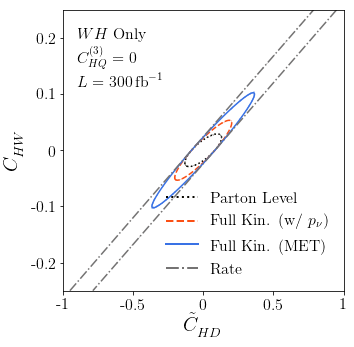

In [213]:
x_dw = 1.0
y_dw = 2.5

fig, validation_plot_dw = plot_contours(
    [ fi_truth_mean_dw, fi_sally_full_mean_dw, fi_sally_met_mean_dw, fi_rate_mean_dw ],
    [ fi_truth_covariance_dw, fi_sally_full_covariance_dw, fi_sally_met_covariance_dw, fi_rate_covariance_dw ],
    colors=[ col_parton, col_sally_full, col_sally_met, col_rate ],
    linestyles=[ 'dotted', 'dashed', 'solid', '-.' ],
    xrange=(-x_dw, x_dw),
    yrange=(-y_dw, y_dw),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
    scale_x=1.0,
    scale_y=10.,
)

plt.legend(handles=legend_elements_sig, loc='lower right', frameon=False)

plt.text(-.9*x_dw,.80*y_dw,r'$WH$ Only',fontsize=16)
plt.text(-.9*x_dw,.60*y_dw,r'$C_{HQ}^{(3)} = 0$',fontsize=16)
plt.text(-.9*x_dw,.45*y_dw,r'$L = 300\,\mathrm{fb}^{-1}$',fontsize=16)
plt.savefig('plots/validation_plot_dw.eps',format='eps')

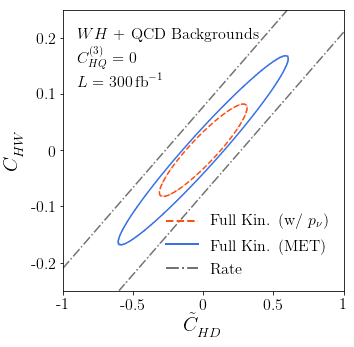

In [214]:
fig, validation_plot_wbkgs_dw = plot_contours(
    [ fi_sally_wbkgs_full_mean_dw, fi_sally_wbkgs_met_mean_dw, fi_wbkgs_rate_mean_dw ],
    [ fi_sally_wbkgs_full_covariance_dw, fi_sally_wbkgs_met_covariance_dw, fi_wbkgs_rate_covariance_dw ],
    colors=[ col_sally_full, col_sally_met, col_rate ],
    linestyles=[ 'dashed', 'solid', '-.' ],
    xrange=(-x_dw, x_dw),
    yrange=(-y_dw, y_dw),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
    scale_x=1.0,
    scale_y=10.,
)

plt.legend(handles=legend_elements, loc='lower right', frameon=False)

plt.text(-.9*x_dw,.80*y_dw,r'$WH$ + QCD Backgrounds',fontsize=16)
plt.text(-.9*x_dw,.60*y_dw,r'$C_{HQ}^{(3)} = 0$',fontsize=16)
plt.text(-.9*x_dw,.45*y_dw,r'$L = 300\,\mathrm{fb}^{-1}$',fontsize=16)
plt.savefig('plots/validation_plot_wbkgs_dw.eps',format='eps')

### ${\tilde{C}}_{HD} - C_{HQ}^{(3)}$

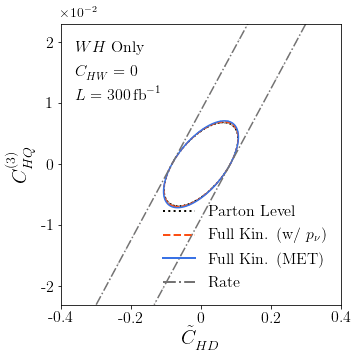

In [215]:
x_dq = 0.4
y_dq = 2.3

validation_plot_dq = plot_contours(
    [ fi_truth_mean_dq, fi_sally_full_mean_dq, fi_sally_met_mean_dq, fi_rate_mean_dq ],
    [ fi_truth_covariance_dq, fi_sally_full_covariance_dq, fi_sally_met_covariance_dq, fi_rate_covariance_dq ],
    colors=[ col_parton, col_sally_full, col_sally_met, col_rate ],
    linestyles=[ 'dotted', 'dashed', 'solid', '-.' ],
    xrange=(-x_dq,x_dq),
    yrange=(-y_dq,y_dq),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=1.0,
    scale_y=1.,
)

plt.legend(handles=legend_elements_sig, loc='lower right', frameon=False)

plt.text(-1*x_dq, 1.05*y_dq, r'$\times 10^{-2}$', fontsize=14)
plt.text(-.9*x_dq,.8*y_dq,r'$WH$ Only',fontsize=16)
plt.text(-.9*x_dq,.6*y_dq,r'$C_{HW}^{\phantom{(3)}} = 0$',fontsize=16)
plt.text(-.9*x_dq,.45*y_dq,r'$L = 300\,\mathrm{fb}^{-1}$',fontsize=16)
plt.savefig('plots/validation_plot_dq.eps',format='eps')

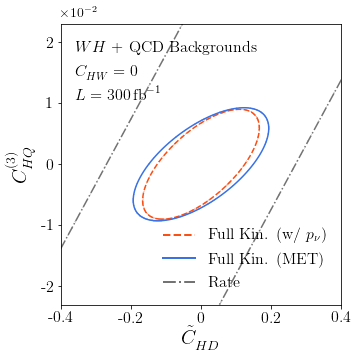

In [216]:
validation_plot_wbkgs_dq = plot_contours(
    [ fi_sally_wbkgs_full_mean_dq, fi_sally_wbkgs_met_mean_dq, fi_wbkgs_rate_mean_dq ],
    [ fi_sally_wbkgs_full_covariance_dq, fi_sally_wbkgs_met_covariance_dq, fi_wbkgs_rate_covariance_dq ],
    colors=[ col_sally_full, col_sally_met, col_rate ],
    linestyles=[ 'dashed', 'solid', '-.' ],
    xrange=(-x_dq,x_dq),
    yrange=(-y_dq,y_dq),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=1.0,
    scale_y=1.,
)

plt.legend(handles=legend_elements, loc='lower right', frameon=False)

plt.text(-1*x_dq, 1.05*y_dq, r'$\times 10^{-2}$', fontsize=14)
plt.text(-.9*x_dq,.8*y_dq,r'$WH$ + QCD Backgrounds',fontsize=16)
plt.text(-.9*x_dq,.6*y_dq,r'$C_{HW}^{\phantom{(3)}} = 0$',fontsize=16)
plt.text(-.9*x_dq,.45*y_dq,r'$L = 300\,\mathrm{fb}^{-1}$',fontsize=16)
plt.savefig('plots/validation_plot_wbkgs_dq.eps',format='eps')

### $C_{HW}^{\phantom{(3)}} - C_{HQ}^{(3)}$

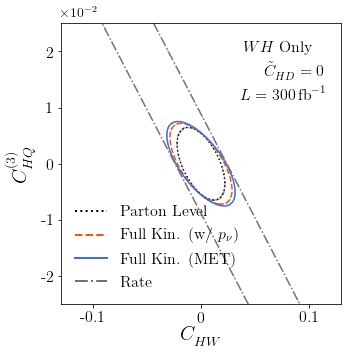

In [217]:
x_wq = 1.3
y_wq = 2.5

validation_plot_wq = plot_contours(
    [ fi_truth_mean_wq, fi_sally_full_mean_wq, fi_sally_met_mean_wq, fi_rate_mean_wq ],
    [ fi_truth_covariance_wq, fi_sally_full_covariance_wq, fi_sally_met_covariance_wq, fi_rate_covariance_wq ],
    colors=[ col_parton, col_sally_full, col_sally_met, col_rate ],
    linestyles=[ 'dotted', 'dashed', 'solid', '-.' ],
    xrange=(-x_wq,x_wq),
    yrange=(-y_wq,y_wq),
    contour_distance=2.4476,
    xlabel=r'$C_{HW}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=10.,
    scale_y=1.,
)

plt.legend(handles=legend_elements_sig, loc='lower left', frameon=False)

plt.text(-1*x_wq, 1.05*y_wq, r'$\times 10^{-2}$', fontsize=14)
plt.text(.30*x_wq,.8*y_wq,r'$WH$ Only',fontsize=16)
plt.text(.45*x_wq,.6*y_wq,r'$\tilde{C}_{HD}^{\phantom{(3)}} = 0$',fontsize=16)
plt.text(.28*x_wq,.45*y_wq,r'$L = 300\,\mathrm{fb}^{-1}$',fontsize=16)
plt.savefig('plots/validation_plot_wq.eps',format='eps')

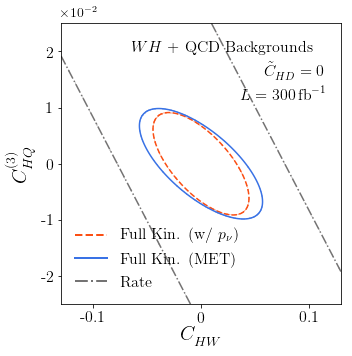

In [218]:
validation_plot_wbkgs_wq = plot_contours(
    [ fi_sally_wbkgs_full_mean_wq, fi_sally_wbkgs_met_mean_wq, fi_wbkgs_rate_mean_wq ],
    [ fi_sally_wbkgs_full_covariance_wq, fi_sally_wbkgs_met_covariance_wq, fi_wbkgs_rate_covariance_wq ],
    colors=[ col_sally_full, col_sally_met, col_rate ],
    linestyles=[ 'dashed', 'solid', '-.' ],
    xrange=(-x_wq,x_wq),
    yrange=(-y_wq,y_wq),
    contour_distance=2.4476,
    xlabel=r'$C_{HW}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=10.,
    scale_y=1.,
)

plt.legend(handles=legend_elements, loc='lower left', frameon=False)

plt.text(-1*x_wq, 1.05*y_wq, r'$\times 10^{-2}$', fontsize=14)
plt.text(-.50*x_wq,.8*y_wq,r'$WH$ + QCD Backgrounds',fontsize=16)
plt.text(.45*x_wq,.6*y_wq,r'$\tilde{C}_{HD}^{\phantom{(3)}} = 0$',fontsize=16)
plt.text(.28*x_wq,.45*y_wq,r'$L = 300\,\mathrm{fb}^{-1}$',fontsize=16)
plt.savefig('plots/validation_plot_wbkgs_wq.eps',format='eps')

# Information in Histograms

## Load Arrays

In [163]:
fi_hist_stxs_outfile = './fisher_info/fi_hist_stxs.npz'
fi_hist_stxs_cov_outfile = './fisher_info/fi_hist_stxs_cov.npz'

fi_stxs_3bins_wph_mu_mean = np.load(fi_hist_stxs_outfile)['arr_0'][0]
fi_stxs_3bins_wph_e_mean = np.load(fi_hist_stxs_outfile)['arr_0'][1]
fi_stxs_3bins_wmh_mu_mean = np.load(fi_hist_stxs_outfile)['arr_0'][2]
fi_stxs_3bins_wmh_e_mean = np.load(fi_hist_stxs_outfile)['arr_0'][3]
fi_stxs_4bins_wph_mu_mean = np.load(fi_hist_stxs_outfile)['arr_0'][4]
fi_stxs_4bins_wph_e_mean = np.load(fi_hist_stxs_outfile)['arr_0'][5]
fi_stxs_4bins_wmh_mu_mean = np.load(fi_hist_stxs_outfile)['arr_0'][6]
fi_stxs_4bins_wmh_e_mean = np.load(fi_hist_stxs_outfile)['arr_0'][7]
fi_stxs_5bins_wph_mu_mean = np.load(fi_hist_stxs_outfile)['arr_0'][8]
fi_stxs_5bins_wph_e_mean = np.load(fi_hist_stxs_outfile)['arr_0'][9]
fi_stxs_5bins_wmh_mu_mean = np.load(fi_hist_stxs_outfile)['arr_0'][10]
fi_stxs_5bins_wmh_e_mean = np.load(fi_hist_stxs_outfile)['arr_0'][11]
fi_stxs_6bins_wph_mu_mean = np.load(fi_hist_stxs_outfile)['arr_0'][12]
fi_stxs_6bins_wph_e_mean = np.load(fi_hist_stxs_outfile)['arr_0'][13]
fi_stxs_6bins_wmh_mu_mean = np.load(fi_hist_stxs_outfile)['arr_0'][14]
fi_stxs_6bins_wmh_e_mean = np.load(fi_hist_stxs_outfile)['arr_0'][15]


fi_stxs_3bins_wph_mu_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][0]
fi_stxs_3bins_wph_e_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][1]
fi_stxs_3bins_wmh_mu_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][2]
fi_stxs_3bins_wmh_e_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][3]
fi_stxs_4bins_wph_mu_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][4]
fi_stxs_4bins_wph_e_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][5]
fi_stxs_4bins_wmh_mu_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][6]
fi_stxs_4bins_wmh_e_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][7]
fi_stxs_5bins_wph_mu_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][8]
fi_stxs_5bins_wph_e_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][9]
fi_stxs_5bins_wmh_mu_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][10]
fi_stxs_5bins_wmh_e_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][11]
fi_stxs_6bins_wph_mu_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][12]
fi_stxs_6bins_wph_e_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][13]
fi_stxs_6bins_wmh_mu_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][14]
fi_stxs_6bins_wmh_e_covariance = np.load(fi_hist_stxs_cov_outfile)['arr_0'][15]

In [164]:
fi_hist_2d_outfile = './fisher_info/fi_hist_2d.npz'
fi_hist_2d_cov_outfile = './fisher_info/fi_hist_2d_cov.npz'

fi_imp_stxs_wph_mu_mean = np.load(fi_hist_2d_outfile)['arr_0'][0]
fi_imp_stxs_wph_e_mean = np.load(fi_hist_2d_outfile)['arr_0'][1] 
fi_imp_stxs_wmh_mu_mean = np.load(fi_hist_2d_outfile)['arr_0'][2] 
fi_imp_stxs_wmh_e_mean = np.load(fi_hist_2d_outfile)['arr_0'][3] 
#fi_imp2_stxs_wph_mu_mean = np.load(fi_hist_2d_outfile)['arr_0'][4] 
#fi_imp2_stxs_wph_e_mean = np.load(fi_hist_2d_outfile)['arr_0'][5] 
#fi_imp2_stxs_wmh_mu_mean = np.load(fi_hist_2d_outfile)['arr_0'][6] 
#fi_imp2_stxs_wmh_e_mean = np.load(fi_hist_2d_outfile)['arr_0'][7]
#fi_imp4_stxs_wph_mu_mean = np.load(fi_hist_2d_outfile)['arr_0'][8] 
#fi_imp4_stxs_wph_e_mean = np.load(fi_hist_2d_outfile)['arr_0'][9] 
#fi_imp4_stxs_wmh_mu_mean = np.load(fi_hist_2d_outfile)['arr_0'][10] 
#fi_imp4_stxs_wmh_e_mean = np.load(fi_hist_2d_outfile)['arr_0'][11] 


fi_imp_stxs_wph_mu_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][0]
fi_imp_stxs_wph_e_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][1]
fi_imp_stxs_wmh_mu_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][2]
fi_imp_stxs_wmh_e_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][3]
#fi_imp2_stxs_wph_mu_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][4]
#fi_imp2_stxs_wph_e_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][5]
#fi_imp2_stxs_wmh_mu_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][6]
#fi_imp2_stxs_wmh_e_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][7]
#fi_imp4_stxs_wph_mu_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][8]
#fi_imp4_stxs_wph_e_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][9]
#fi_imp4_stxs_wmh_mu_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][10]
#fi_imp4_stxs_wmh_e_covariance = np.load(fi_hist_2d_cov_outfile)['arr_0'][11]

Combine...

In [165]:
fi_stxs_3bins_mean = fi_stxs_3bins_wph_mu_mean + fi_stxs_3bins_wph_e_mean + fi_stxs_3bins_wmh_mu_mean + fi_stxs_3bins_wmh_e_mean
fi_stxs_3bins_covariance = fi_stxs_3bins_wph_mu_covariance + fi_stxs_3bins_wph_e_covariance + fi_stxs_3bins_wmh_mu_covariance + fi_stxs_3bins_wmh_e_covariance

fi_stxs_4bins_mean = fi_stxs_4bins_wph_mu_mean + fi_stxs_4bins_wph_e_mean + fi_stxs_4bins_wmh_mu_mean + fi_stxs_4bins_wmh_e_mean
fi_stxs_4bins_covariance = fi_stxs_4bins_wph_mu_covariance + fi_stxs_4bins_wph_e_covariance + fi_stxs_4bins_wmh_mu_covariance + fi_stxs_4bins_wmh_e_covariance

fi_stxs_5bins_mean = fi_stxs_5bins_wph_mu_mean + fi_stxs_5bins_wph_e_mean + fi_stxs_5bins_wmh_mu_mean + fi_stxs_5bins_wmh_e_mean
fi_stxs_5bins_covariance = fi_stxs_5bins_wph_mu_covariance + fi_stxs_5bins_wph_e_covariance + fi_stxs_5bins_wmh_mu_covariance + fi_stxs_5bins_wmh_e_covariance

fi_stxs_6bins_mean = fi_stxs_6bins_wph_mu_mean + fi_stxs_6bins_wph_e_mean + fi_stxs_6bins_wmh_mu_mean + fi_stxs_6bins_wmh_e_mean
fi_stxs_6bins_covariance = fi_stxs_6bins_wph_mu_covariance + fi_stxs_6bins_wph_e_covariance + fi_stxs_6bins_wmh_mu_covariance + fi_stxs_6bins_wmh_e_covariance

In [166]:
fi_imp_stxs_mean = fi_imp_stxs_wph_mu_mean + fi_imp_stxs_wph_e_mean + fi_imp_stxs_wmh_mu_mean + fi_imp_stxs_wmh_e_mean
fi_imp_stxs_covariance = fi_imp_stxs_wph_mu_covariance + fi_imp_stxs_wph_e_covariance + fi_imp_stxs_wmh_mu_covariance + fi_imp_stxs_wmh_e_covariance

#fi_imp2_stxs_mean = fi_imp2_stxs_wph_mu_mean + fi_imp2_stxs_wph_e_mean + fi_imp2_stxs_wmh_mu_mean + fi_imp2_stxs_wmh_e_mean
#fi_imp2_stxs_covariance = fi_imp2_stxs_wph_mu_covariance + fi_imp2_stxs_wph_e_covariance + fi_imp2_stxs_wmh_mu_covariance + fi_imp2_stxs_wmh_e_covariance

#fi_imp4_stxs_mean = fi_imp4_stxs_wph_mu_mean + fi_imp4_stxs_wph_e_mean + fi_imp4_stxs_wmh_mu_mean + fi_imp4_stxs_wmh_e_mean
#fi_imp4_stxs_covariance = fi_imp4_stxs_wph_mu_covariance + fi_imp4_stxs_wph_e_covariance + fi_imp4_stxs_wmh_mu_covariance + fi_imp4_stxs_wmh_e_covariance

## Plots of Information in $p_{T,W}$

### Rotate and Project the F.I. for Plotting:

Project out systematics:

In [167]:
fi_stxs_3bins_mean_nosyst, fi_stxs_3bins_covariance_nosyst = project_information(fi_stxs_3bins_mean, [0,1,2,3], covariance=fi_stxs_3bins_covariance)
#fi_stxs_4bins_mean_nosyst, fi_stxs_4bins_covariance_nosyst = project_information(fi_stxs_4bins_mean, [0,1,2,3], covariance=fi_stxs_4bins_covariance)
fi_stxs_5bins_mean_nosyst, fi_stxs_5bins_covariance_nosyst = project_information(fi_stxs_5bins_mean, [0,1,2,3], covariance=fi_stxs_5bins_covariance)
fi_stxs_6bins_mean_nosyst, fi_stxs_6bins_covariance_nosyst = project_information(fi_stxs_6bins_mean, [0,1,2,3], covariance=fi_stxs_6bins_covariance)

In [168]:
fi_stxs_3bins_mean_rot, fi_stxs_3bins_covariance_rot = rotate(fi_stxs_3bins_mean_nosyst, covariance=fi_stxs_3bins_covariance_nosyst)
#fi_stxs_4bins_mean_rot, fi_stxs_4bins_covariance_rot = rotate(fi_stxs_4bins_mean_nosyst, covariance=fi_stxs_4bins_covariance_nosyst)
fi_stxs_5bins_mean_rot, fi_stxs_5bins_covariance_rot = rotate(fi_stxs_5bins_mean_nosyst, covariance=fi_stxs_5bins_covariance_nosyst)
fi_stxs_6bins_mean_rot, fi_stxs_6bins_covariance_rot = rotate(fi_stxs_6bins_mean_nosyst, covariance=fi_stxs_6bins_covariance_nosyst)

#### Projected

In [169]:
fi_sally_wbkgs_ptw_mean_dw, fi_sally_wbkgs_ptw_covariance_dw = project_information(fi_sally_wbkgs_ptw_mean_rot, [0,1], covariance=fi_sally_wbkgs_ptw_covariance_rot)
fi_stxs_3bins_mean_dw, fi_stxs_3bins_covariance_dw = project_information(fi_stxs_3bins_mean_rot, [0,1], covariance=fi_stxs_3bins_covariance_rot)
fi_stxs_5bins_mean_dw, fi_stxs_5bins_covariance_dw = project_information(fi_stxs_5bins_mean_rot, [0,1], covariance=fi_stxs_5bins_covariance_rot)
fi_stxs_6bins_mean_dw, fi_stxs_6bins_covariance_dw = project_information(fi_stxs_6bins_mean_rot, [0,1], covariance=fi_stxs_6bins_covariance_rot)

In [170]:
fi_sally_wbkgs_ptw_mean_dq, fi_sally_wbkgs_ptw_covariance_dq = project_information(fi_sally_wbkgs_ptw_mean_rot, [0,2], covariance=fi_sally_wbkgs_ptw_covariance_rot)
fi_stxs_3bins_mean_dq, fi_stxs_3bins_covariance_dq = project_information(fi_stxs_3bins_mean_rot, [0,2], covariance=fi_stxs_3bins_covariance_rot)
fi_stxs_5bins_mean_dq, fi_stxs_5bins_covariance_dq = project_information(fi_stxs_5bins_mean_rot, [0,2], covariance=fi_stxs_5bins_covariance_rot)
fi_stxs_6bins_mean_dq, fi_stxs_6bins_covariance_dq = project_information(fi_stxs_6bins_mean_rot, [0,2], covariance=fi_stxs_6bins_covariance_rot)

In [171]:
fi_sally_wbkgs_ptw_mean_wq, fi_sally_wbkgs_ptw_covariance_wq = project_information(fi_sally_wbkgs_ptw_mean_rot, [1,2], covariance=fi_sally_wbkgs_ptw_covariance_rot)
fi_stxs_3bins_mean_wq, fi_stxs_3bins_covariance_wq = project_information(fi_stxs_3bins_mean_rot, [1,2], covariance=fi_stxs_3bins_covariance_rot)
fi_stxs_5bins_mean_wq, fi_stxs_5bins_covariance_wq = project_information(fi_stxs_5bins_mean_rot, [1,2], covariance=fi_stxs_5bins_covariance_rot)
fi_stxs_6bins_mean_wq, fi_stxs_6bins_covariance_wq = project_information(fi_stxs_6bins_mean_rot, [1,2], covariance=fi_stxs_6bins_covariance_rot)

#### Profiled

In [172]:
fi_sally_wbkgs_ptw_mean_prof_dw, fi_sally_wbkgs_ptw_covariance_prof_dw = profile_information( fi_sally_wbkgs_ptw_mean_rot, [0,1], covariance = fi_sally_wbkgs_ptw_covariance_rot)
fi_stxs_3bins_mean_prof_dw, fi_stxs_3bins_covariance_prof_dw = profile_information( fi_stxs_3bins_mean_rot, [0,1], covariance = fi_stxs_3bins_covariance_rot)
fi_stxs_5bins_mean_prof_dw, fi_stxs_5bins_covariance_prof_dw = profile_information( fi_stxs_5bins_mean_rot, [0,1], covariance = fi_stxs_5bins_covariance_rot)
fi_stxs_6bins_mean_prof_dw, fi_stxs_6bins_covariance_prof_dw = profile_information( fi_stxs_6bins_mean_rot, [0,1], covariance = fi_stxs_6bins_covariance_rot)

In [173]:
fi_sally_wbkgs_ptw_mean_prof_dq, fi_sally_wbkgs_ptw_covariance_prof_dq = profile_information( fi_sally_wbkgs_ptw_mean_rot, [0,2], covariance = fi_sally_wbkgs_ptw_covariance_rot)
fi_stxs_3bins_mean_prof_dq, fi_stxs_3bins_covariance_prof_dq = profile_information( fi_stxs_3bins_mean_rot, [0,2], covariance = fi_stxs_3bins_covariance_rot)
fi_stxs_5bins_mean_prof_dq, fi_stxs_5bins_covariance_prof_dq = profile_information( fi_stxs_5bins_mean_rot, [0,2], covariance = fi_stxs_5bins_covariance_rot)
fi_stxs_6bins_mean_prof_dq, fi_stxs_6bins_covariance_prof_dq = profile_information( fi_stxs_6bins_mean_rot, [0,2], covariance = fi_stxs_6bins_covariance_rot)

In [174]:
fi_sally_wbkgs_ptw_mean_prof_wq, fi_sally_wbkgs_ptw_covariance_prof_wq = profile_information( fi_sally_wbkgs_ptw_mean_rot, [1,2], covariance = fi_sally_wbkgs_ptw_covariance_rot)
fi_stxs_3bins_mean_prof_wq, fi_stxs_3bins_covariance_prof_wq = profile_information( fi_stxs_3bins_mean_rot, [1,2], covariance = fi_stxs_3bins_covariance_rot)
fi_stxs_5bins_mean_prof_wq, fi_stxs_5bins_covariance_prof_wq = profile_information( fi_stxs_5bins_mean_rot, [1,2], covariance = fi_stxs_5bins_covariance_rot)
fi_stxs_6bins_mean_prof_wq, fi_stxs_6bins_covariance_prof_wq = profile_information( fi_stxs_6bins_mean_rot, [1,2], covariance = fi_stxs_6bins_covariance_rot)

### Plots of Information

Here we show the limits obtained from histograms of $p_{T,W}$ with various binnings:
* The original STXS, with 3 bins (boundaries at 0, 150, 250 GeV)
* STXS with an additional bin boundary at 75 GeV
* STXS with additional bin boundaries at 75 and 400 GeV
* A very differential histogram, with bin boundaires every 25 GeV up to 325 GeV, with extra boundaries at 375, 425, and 500 GeV
* the infinite binning limit, obtained by training a neural network (with `SALLY`) on only the observable $p_{T,W}$

In [175]:
ptw_legend = [
    Line2D([0],[0], color=col_sally_ptw, ls='-', label=r'Full $p_{T,W}$ dist.'),
    Line2D([0],[0], color=col_stxs_6bins, ls='-.', label='STXS, 6 bins'),
    Line2D([0],[0], color=col_stxs_5bins, ls='--', label='STXS, stage 1.1'),
    Line2D([0],[0], color=col_stxs_3bins, ls=':', label='STXS, stage 1'),
]

#### Projected

[]

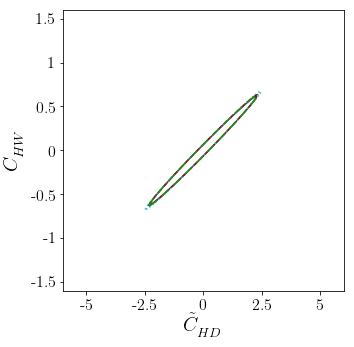

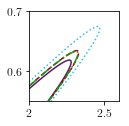

In [199]:
fig = plt.figure()

fig1, dw_contours = plot_contours(
    [  
     fi_sally_wbkgs_ptw_mean_dw, 
     fi_stxs_3bins_mean_dw,
     fi_stxs_5bins_mean_dw,
     fi_stxs_6bins_mean_dw,
    ],
#    [  
#     fi_sally_wbkgs_ptw_covariance_dw, 
#     fi_stxs_3bins_covariance_dw,
#     fi_stxs_5bins_covariance_dw,
#     fi_stxs_6bins_covariance_dw,
#    ],    
    colors=[ col_sally_ptw, col_stxs_3bins, col_stxs_5bins, col_stxs_6bins ],
    linestyles=[ '-', ':', '--', '-.' ],
    xrange=(-6,6),
    yrange=(-16,16),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
    scale_x=1.0,
    scale_y=10.,
)

#ax2 = fig.add_axes([0.65,0.25,0.25,0.25])

#fig1.axes.append(dw_contours)

fig2, subplot = plot_contours(
    [  
        fi_sally_wbkgs_ptw_mean_dw,
        fi_stxs_3bins_mean_dw,
        fi_stxs_5bins_mean_dw,
        fi_stxs_6bins_mean_dw,
    ],
#    fisher_information_covariances = [  
#        fi_sally_wbkgs_ptw_covariance_dw,
#        fi_stxs_3bins_covariance_dw,
#        fi_stxs_5bins_covariance_dw,
#        fi_stxs_6bins_covariance_dw,
#    ],
    colors=[ col_sally_ptw, col_stxs_3bins, col_stxs_5bins, col_stxs_6bins ],
    linestyles=[ '-', ':', '--', '-.' ],
    xrange=(2,2.6),
    yrange=(5.5,7),
    contour_distance=2.4476,
    xlabel='',
    ylabel='',
    scale_x=1.0,
    scale_y=10.,
)

subplot.set_position([1.5,0.25,0.25,0.25])
for tick in subplot.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in subplot.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
fig1.axes.append(subplot)
subplot.plot()

#fig = plt.figure()
#dw_contours.plot()
#fig.add_subplot(111)
#subplot.plot()

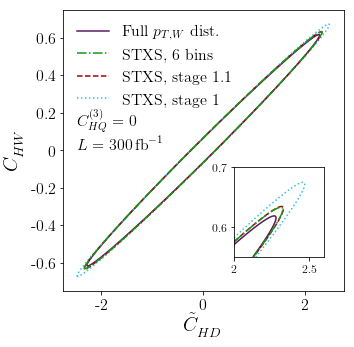

In [212]:
fig, dw_contours = plot_contours(
    [  
        fi_sally_wbkgs_ptw_mean_dw,
        fi_stxs_3bins_mean_dw,
        fi_stxs_5bins_mean_dw,
        fi_stxs_6bins_mean_dw,
    ],
#    fisher_information_covariances = [  
#        fi_sally_wbkgs_ptw_covariance_dw,
#        fi_stxs_3bins_covariance_dw,
#        fi_stxs_5bins_covariance_dw,
#        fi_stxs_6bins_covariance_dw,
#    ],
    colors=[ col_sally_ptw, col_stxs_3bins, col_stxs_5bins, col_stxs_6bins ],
    linestyles=[ '-', ':', '--', '-.' ],
    xrange=(-2.75,2.75),
    yrange=(-7.5,7.5),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
    scale_x=1.0,
    scale_y=10.,
)
#fig.set_size_inches(5,5)
plt.legend(handles=ptw_legend, loc='upper left', frameon=False)

plt.text(-0.9*dw_contours.get_xlim()[1], 0.15*dw_contours.get_ylim()[1], r'$C_{HQ}^{(3)} = 0$', fontsize=16)
plt.text(-0.9*dw_contours.get_xlim()[1], 0.0*dw_contours.get_ylim()[1], r'$L = 300\,\mathrm{fb}^{-1}$',fontsize=16)

subplot.set_position([0.65,0.25,0.25,0.25])
subplot.figure=fig
fig.axes.append(subplot)
fig.add_axes(subplot)

fig.savefig('plots/stxs_contours_dw_proj_inset.eps',format='eps')

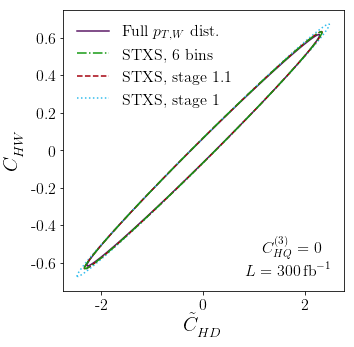

In [178]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_ptw_mean_dw,
        fi_stxs_3bins_mean_dw,
        fi_stxs_5bins_mean_dw,
        fi_stxs_6bins_mean_dw,
    ],
#    fisher_information_covariances = [  
#        fi_sally_wbkgs_ptw_covariance_dw,
#        fi_stxs_3bins_covariance_dw,
#        fi_stxs_5bins_covariance_dw,
#        fi_stxs_6bins_covariance_dw,
#    ], 
    colors=[ col_sally_ptw, col_stxs_3bins, col_stxs_5bins, col_stxs_6bins ],
    linestyles=[ '-', ':', '--', '-.' ],
    xrange=(-2.75,2.75),
    yrange=(-7.5,7.5),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
    scale_x=1.0,
    scale_y=10.,
)

plt.legend(handles=ptw_legend, loc='upper left',frameon=False)
plt.text(0.42*ax.get_xlim()[1], -.75*ax.get_ylim()[1], r'$C_{HQ}^{(3)} = 0$', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], -.9*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/stxs_contours_dw_proj.pdf')

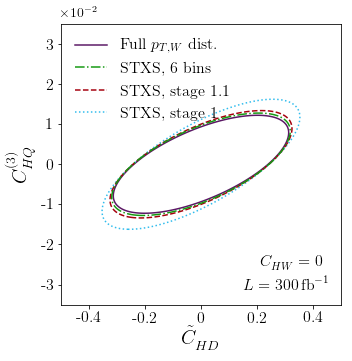

In [201]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_ptw_mean_dq,
        fi_stxs_3bins_mean_dq,
        fi_stxs_5bins_mean_dq,
        fi_stxs_6bins_mean_dq,
    ],
#    fisher_information_covariances = [  
#        fi_sally_wbkgs_ptw_covariance_dq,
#        fi_stxs_3bins_covariance_dq,
#        fi_stxs_5bins_covariance_dq,
#        fi_stxs_6bins_covariance_dq,
#    ],
    colors=[ col_sally_ptw, col_stxs_3bins, col_stxs_5bins, col_stxs_6bins ],
    linestyles=[ '-', ':', '--', '-.' ],
    xrange=(-.5,.5),
    yrange=(-3.5,3.5),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=1.0,
    scale_y=1.,
)

plt.legend(handles=ptw_legend, loc='upper left',frameon=False)
plt.text(-1*ax.get_xlim()[1], 1.05*ax.get_ylim()[1], r'$\times 10^{-2}$', fontsize=14)
plt.text(0.42*ax.get_xlim()[1], -.75*ax.get_ylim()[1], r'$C_{HW}^{\phantom{(3)}} = 0$', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], -.9*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/stxs_contours_dq_proj.eps',format='eps')

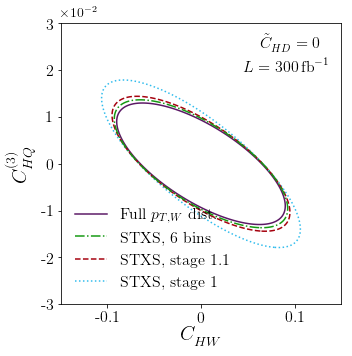

In [202]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_ptw_mean_wq,
        fi_stxs_3bins_mean_wq,
        fi_stxs_5bins_mean_wq,
        fi_stxs_6bins_mean_wq,
    ],
#    fisher_information_covariances = [  
#        fi_sally_wbkgs_ptw_covariance_wq,
#        fi_stxs_3bins_covariance_wq,
#        fi_stxs_5bins_covariance_wq,
#        fi_stxs_6bins_covariance_wq,
#    ],
    colors=[ col_sally_ptw, col_stxs_3bins, col_stxs_5bins, col_stxs_6bins ],
    linestyles=[ '-', ':', '--', '-.' ],
    xrange=(-1.5,1.5),
    yrange=(-3,3),
    contour_distance=2.4476,
    xlabel=r'$C_{HW}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=10.0,
    scale_y=1.,
)

plt.legend(handles=ptw_legend, loc='lower left',frameon=False)
plt.text(-1*ax.get_xlim()[1], 1.05*ax.get_ylim()[1], r'$\times 10^{-2}$', fontsize=14)
plt.text(.42*ax.get_xlim()[1], 0.8*ax.get_ylim()[1],r'$\tilde{C}_{HD}^{\phantom{(3)}} = 0$',fontsize=16)
plt.text(.30*ax.get_xlim()[1], .65*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/stxs_contours_wq_proj.eps',format='eps')

#### Profiled

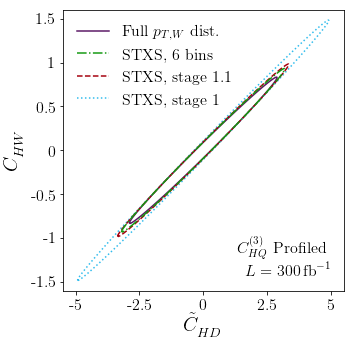

In [203]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_ptw_mean_prof_dw,
        fi_stxs_3bins_mean_prof_dw,
        fi_stxs_5bins_mean_prof_dw,
        fi_stxs_6bins_mean_prof_dw,
    ],
#    fisher_information_covariances = [  
#        fi_sally_wbkgs_ptw_covariance_prof_dw,
#        fi_stxs_3bins_covariance_prof_dw,
#        fi_stxs_5bins_covariance_prof_dw,
#        fi_stxs_6bins_covariance_prof_dw,
#    ],
    colors=[ col_sally_ptw, col_stxs_3bins, col_stxs_5bins, col_stxs_6bins ],
    linestyles=[ '-', ':', '--', '-.' ],
    xrange=(-5.5,5.5),
    yrange=(-16,16),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
    scale_x=1.0,
    scale_y=10.,
)

plt.legend(handles=ptw_legend, loc='upper left',frameon=False)
plt.text(0.24*ax.get_xlim()[1], -.75*ax.get_ylim()[1], r'$C_{HQ}^{(3)}$ Profiled', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], -.9*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/stxs_contours_dw_prof.eps',format='eps')

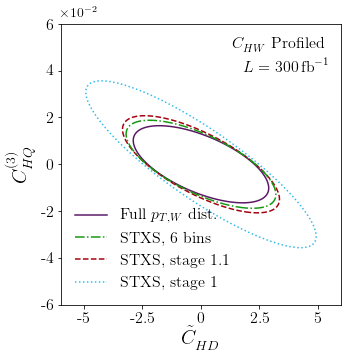

In [204]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_ptw_mean_prof_dq,
        fi_stxs_3bins_mean_prof_dq,
        fi_stxs_5bins_mean_prof_dq,
        fi_stxs_6bins_mean_prof_dq,
    ],
#    fisher_information_covariances = [  
#        fi_sally_wbkgs_ptw_covariance_prof_dq,
#        fi_stxs_3bins_covariance_prof_dq,
#        fi_stxs_5bins_covariance_prof_dq,
#        fi_stxs_6bins_covariance_prof_dq,
#    ],
    colors=[ col_sally_ptw, col_stxs_3bins, col_stxs_5bins, col_stxs_6bins ],
    linestyles=[ '-', ':', '--', '-.' ],
    xrange=(-6,6),
    yrange=(-6,6),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=1.0,
    scale_y=1.,
)

plt.legend(handles=ptw_legend, loc='lower left',frameon=False)
plt.text(-1*ax.get_xlim()[1], 1.05*ax.get_ylim()[1], r'$\times 10^{-2}$', fontsize=14)
plt.text(0.22*ax.get_xlim()[1], 0.8*ax.get_ylim()[1], r'$C_{HW}^{\phantom{(3)}}$ Profiled', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], 0.65*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/stxs_contours_dq_prof.eps',format='eps')

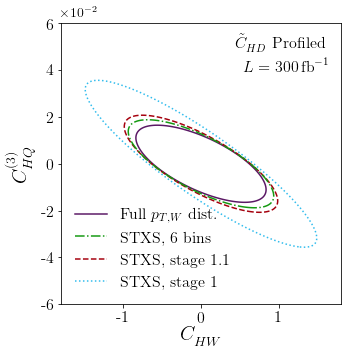

In [205]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_ptw_mean_prof_wq,
        fi_stxs_3bins_mean_prof_wq,
        fi_stxs_5bins_mean_prof_wq,
        fi_stxs_6bins_mean_prof_wq,
    ],
#    fisher_information_covariances = [  
#        fi_sally_wbkgs_ptw_covariance_prof_wq,
#        fi_stxs_3bins_covariance_prof_wq,
#        fi_stxs_5bins_covariance_prof_wq,
#        fi_stxs_6bins_covariance_prof_wq,
#    ],
    colors=[ col_sally_ptw, col_stxs_3bins, col_stxs_5bins, col_stxs_6bins ],
    linestyles=[ '-', ':', '--', '-.' ],
    xrange=(-18,18),
    yrange=(-6,6),
    contour_distance=2.4476,
    xlabel=r'$C_{HW}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=10.0,
    scale_y=1.,
)

plt.legend(handles=ptw_legend, loc='lower left',frameon=False)
plt.text(-1*ax.get_xlim()[1], 1.05*ax.get_ylim()[1], r'$\times 10^{-2}$', fontsize=14)
plt.text(0.24*ax.get_xlim()[1], 0.8*ax.get_ylim()[1],r'$\tilde{C}_{HD}^{\phantom{(3)}}$ Profiled',fontsize=16)
plt.text(0.30*ax.get_xlim()[1], 0.65*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/stxs_contours_wq_prof.eps',format='eps')

## 5.2 1D vs. 2D Histograms

### Combine & Rotate for Plotting

In [184]:
fi_imp_stxs_mean_nosyst, fi_imp_stxs_covariance_nosyst = project_information(fi_imp_stxs_mean, [0,1,2,3], covariance=fi_imp_stxs_covariance)
#fi_imp2_stxs_mean_nosyst, fi_imp2_stxs_covariance_nosyst = project_information(fi_imp2_stxs_mean, [0,1,2,3], covariance=fi_imp2_stxs_covariance)
#fi_imp4_stxs_mean_nosyst, fi_imp4_stxs_covariance_nosyst = project_information(fi_imp4_stxs_mean, [0,1,2,3], covariance=fi_imp4_stxs_covariance)

In [185]:
fi_imp_stxs_mean_rot, fi_imp_stxs_covariance_rot = rotate(fi_imp_stxs_mean_nosyst, covariance=fi_imp_stxs_covariance_nosyst)
#fi_imp2_stxs_mean_rot, fi_imp2_stxs_covariance_rot = rotate(fi_imp2_stxs_mean_nosyst, covariance=fi_imp2_stxs_covariance_nosyst)
#fi_imp4_stxs_mean_rot, fi_imp4_stxs_covariance_rot = rotate(fi_imp4_stxs_mean_nosyst, covariance=fi_imp4_stxs_covariance_nosyst)

#### Projected

In [186]:
fi_sally_wbkgs_met_mean_dw, fi_sally_wbkgs_met_covariance_dw = project_information(fi_sally_wbkgs_met_mean_rot, [0,1], covariance=fi_sally_wbkgs_met_covariance_rot)
fi_sally_wbkgs_2d_mean_dw, fi_sally_wbkgs_2d_covariance_dw = project_information(fi_sally_wbkgs_2d_mean_rot, [0,1], covariance=fi_sally_wbkgs_2d_covariance_rot)
fi_imp_stxs_mean_dw, fi_imp_stxs_covariance_dw = project_information(fi_imp_stxs_mean_rot, [0,1], covariance=fi_imp_stxs_covariance_rot)

In [187]:
fi_sally_wbkgs_met_mean_dq, fi_sally_wbkgs_met_covariance_dq = project_information(fi_sally_wbkgs_met_mean_rot, [0,2], covariance=fi_sally_wbkgs_met_covariance_rot)
fi_sally_wbkgs_2d_mean_dq, fi_sally_wbkgs_2d_covariance_dq = project_information(fi_sally_wbkgs_2d_mean_rot, [0,2], covariance=fi_sally_wbkgs_2d_covariance_rot)
fi_imp_stxs_mean_dq, fi_imp_stxs_covariance_dq = project_information(fi_imp_stxs_mean_rot, [0,2], covariance=fi_imp_stxs_covariance_rot)

In [188]:
fi_sally_wbkgs_met_mean_wq, fi_sally_wbkgs_met_covariance_wq = project_information(fi_sally_wbkgs_met_mean_rot, [1,2], covariance=fi_sally_wbkgs_met_covariance_rot)
fi_sally_wbkgs_2d_mean_wq, fi_sally_wbkgs_2d_covariance_wq = project_information(fi_sally_wbkgs_2d_mean_rot, [1,2], covariance=fi_sally_wbkgs_2d_covariance_rot)
fi_imp_stxs_mean_wq, fi_imp_stxs_covariance_wq = project_information(fi_imp_stxs_mean_rot, [1,2], covariance=fi_imp_stxs_covariance_rot)

#### Profiled

In [189]:
fi_sally_wbkgs_met_mean_prof_dw, fi_sally_wbkgs_met_covariance_prof_dw = profile_information(fi_sally_wbkgs_met_mean_rot, [0,1], covariance=fi_sally_wbkgs_met_covariance_rot)
fi_sally_wbkgs_2d_mean_prof_dw, fi_sally_wbkgs_2d_covariance_prof_dw = profile_information(fi_sally_wbkgs_2d_mean_rot, [0,1], covariance=fi_sally_wbkgs_2d_covariance_rot)
fi_imp_stxs_mean_prof_dw, fi_imp_stxs_covariance_prof_dw = profile_information(fi_imp_stxs_mean_rot, [0,1], covariance=fi_imp_stxs_covariance_rot)

In [190]:
fi_sally_wbkgs_met_mean_prof_dq, fi_sally_wbkgs_met_covariance_prof_dq = profile_information(fi_sally_wbkgs_met_mean_rot, [0,2], covariance=fi_sally_wbkgs_met_covariance_rot)
fi_sally_wbkgs_2d_mean_prof_dq, fi_sally_wbkgs_2d_covariance_prof_dq = profile_information(fi_sally_wbkgs_2d_mean_rot, [0,2], covariance=fi_sally_wbkgs_2d_covariance_rot)
fi_imp_stxs_mean_prof_dq, fi_imp_stxs_covariance_prof_dq = profile_information(fi_imp_stxs_mean_rot, [0,2], covariance=fi_imp_stxs_covariance_rot)

In [191]:
fi_sally_wbkgs_met_mean_prof_wq, fi_sally_wbkgs_met_covariance_prof_wq = profile_information(fi_sally_wbkgs_met_mean_rot, [1,2], covariance=fi_sally_wbkgs_met_covariance_rot)
fi_sally_wbkgs_2d_mean_prof_wq, fi_sally_wbkgs_2d_covariance_prof_wq = profile_information(fi_sally_wbkgs_2d_mean_rot, [1,2], covariance=fi_sally_wbkgs_2d_covariance_rot)
fi_imp_stxs_mean_prof_wq, fi_imp_stxs_covariance_prof_wq = profile_information(fi_imp_stxs_mean_rot, [1,2], covariance=fi_imp_stxs_covariance_rot)

### Plot Comparison of 1D and 2D STXS

Comparison of the STXS, a 2D histogram, ML with 2 observable, and "full" information from `SALLY`

In [192]:
imp_legend = [
    Line2D([0],[0], color=col_sally_met, ls='-', label=r'Full Kin.'),
    Line2D([0],[0], color=col_sally_2d, ls=':', label=r'Full 2D dist.'),
    Line2D([0],[0], color=col_stxs_5bins, ls='--', label='STXS, stage 1.1'),
    Line2D([0],[0], color=col_imp_stxs, ls='-.', label=r'Imp. STXS'),
]

#### Projected

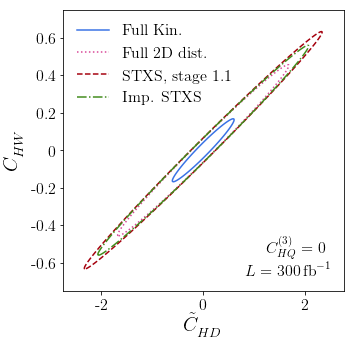

In [206]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_met_mean_dw,
        fi_sally_wbkgs_2d_mean_dw,
        fi_stxs_5bins_mean_dw,
        fi_imp_stxs_mean_dw,
    ],
#    fisher_information_covariances = [
#        fi_sally_wbkgs_met_covariance_dw,
#        fi_sally_wbkgs_2d_covariance_dw,
#        fi_stxs_5bins_covariance_dw,
#        fi_imp_stxs_covariance_dw,
#    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-',':','--','-.'],
    xrange=(-2.75,2.75),
    yrange=(-7.5,7.5),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
    scale_x=1.0,
    scale_y=10.,
)

plt.legend(handles=imp_legend, loc='upper left',frameon=False)
plt.text(0.45*ax.get_xlim()[1], -.75*ax.get_ylim()[1], r'$C_{HQ}^{(3)} = 0$', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], -.9*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/imp_contours_dw_proj.eps',format='eps')

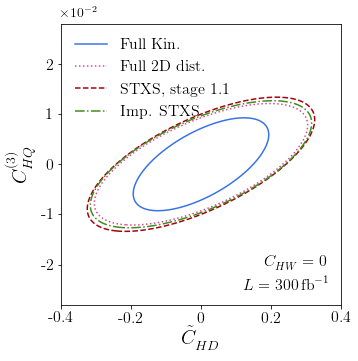

In [207]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_met_mean_dq,
        fi_sally_wbkgs_2d_mean_dq,
        fi_stxs_5bins_mean_dq,
        fi_imp_stxs_mean_dq,
    ],
#    fisher_information_covariances = [
#        fi_sally_wbkgs_met_covariance_dq,
#        fi_sally_wbkgs_2d_covariance_dq,
#        fi_stxs_5bins_covariance_dq,
#        fi_imp_stxs_covariance_dq,
#    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-',':','--','-.'],
    xrange=(-0.4,0.4),
    yrange=(-2.8,2.8),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=1.0,
    scale_y=1.,
)

plt.legend(handles=imp_legend, loc='upper left',frameon=False)
plt.text(-1*ax.get_xlim()[1], 1.05*ax.get_ylim()[1], r'$\times 10^{-2}$', fontsize=14)
plt.text(0.45*ax.get_xlim()[1], -.75*ax.get_ylim()[1], r'$C_{HW}^{\phantom{(3)}} = 0$', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], -.9*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/imp_contours_dq_proj.eps',format='eps')

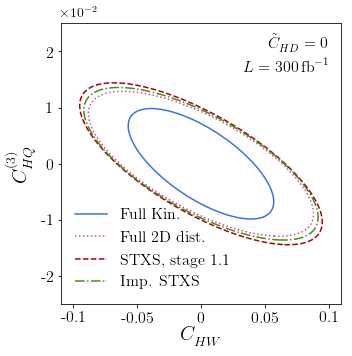

In [208]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_met_mean_wq,
        fi_sally_wbkgs_2d_mean_wq,
        fi_stxs_5bins_mean_wq,
        fi_imp_stxs_mean_wq,
    ],
#    fisher_information_covariances = [
#        fi_sally_wbkgs_met_covariance_wq,
#        fi_sally_wbkgs_2d_covariance_wq,
#        fi_stxs_5bins_covariance_wq,
#        fi_imp_stxs_covariance_wq,
#    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-',':','--','-.'],
    xrange=(-1.1,1.1),
    yrange=(-2.5,2.5),
    contour_distance=2.4476,
    xlabel=r'$C_{HW}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=10.0,
    scale_y=1.,
)

plt.legend(handles=imp_legend, loc='lower left',frameon=False)
plt.text(-1*ax.get_xlim()[1], 1.05*ax.get_ylim()[1], r'$\times 10^{-2}$', fontsize=14)
plt.text(.48*ax.get_xlim()[1], .8*ax.get_ylim()[1],r'$\tilde{C}_{HD}^{\phantom{(3)}} = 0$',fontsize=16)
plt.text(0.30*ax.get_xlim()[1],.65*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/imp_contours_wq_proj.eps',format='eps')

#### Profiled

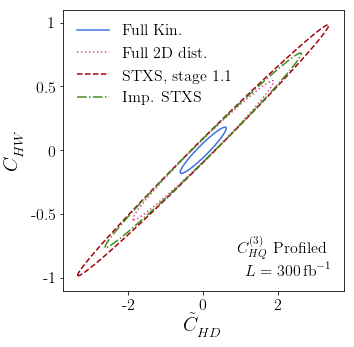

In [209]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_met_mean_prof_dw,
        fi_sally_wbkgs_2d_mean_prof_dw,
        fi_stxs_5bins_mean_prof_dw,
        fi_imp_stxs_mean_prof_dw,
    ],
#    fisher_information_covariances = [
#        fi_sally_wbkgs_met_covariance_prof_dw,
#        fi_sally_wbkgs_2d_covariance_prof_dw,
#        fi_stxs_5bins_covariance_prof_dw,
#        fi_imp_stxs_covariance_prof_dw,
#    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-',':','--','-.'],
    xrange=(-3.75,3.75),
    yrange=(-11,11),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
    scale_x=1.0,
    scale_y=10.,
)

plt.legend(handles=imp_legend, loc='upper left',frameon=False)
plt.text(0.24*ax.get_xlim()[1], -.75*ax.get_ylim()[1], r'$C_{HQ}^{(3)}$ Profiled', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], -.9*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/imp_contours_dw_prof.eps',format='eps')

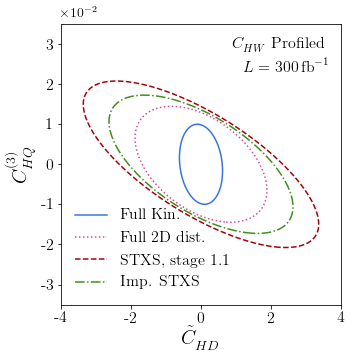

In [210]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_met_mean_prof_dq,
        fi_sally_wbkgs_2d_mean_prof_dq,
        fi_stxs_5bins_mean_prof_dq,
        fi_imp_stxs_mean_prof_dq,
    ],
#    fisher_information_covariances = [
#        fi_sally_wbkgs_met_covariance_prof_dq,
#        fi_sally_wbkgs_2d_covariance_prof_dq,
#        fi_stxs_5bins_covariance_prof_dq,
#        fi_imp_stxs_covariance_prof_dq,
#    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-',':','--','-.'],
    xrange=(-4,4),
    yrange=(-3.5,3.5),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=1.0,
    scale_y=1.,
)

plt.legend(handles=imp_legend, loc='lower left',frameon=False)
plt.text(-1*ax.get_xlim()[1], 1.05*ax.get_ylim()[1], r'$\times 10^{-2}$', fontsize=14)
plt.text(0.22*ax.get_xlim()[1], 0.8*ax.get_ylim()[1], r'$C_{HW}^{\phantom{(3)}}$ Profiled', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], .65*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/imp_contours_dq_prof.eps',format='eps')

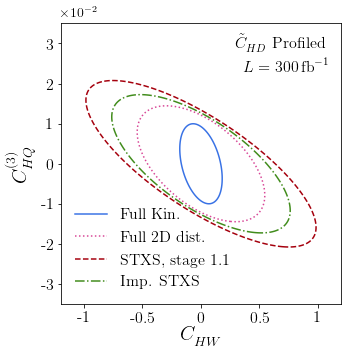

In [211]:
_, ax = plot_contours(
    [  
        fi_sally_wbkgs_met_mean_prof_wq,
        fi_sally_wbkgs_2d_mean_prof_wq,
        fi_stxs_5bins_mean_prof_wq,
        fi_imp_stxs_mean_prof_wq,
    ],
#    fisher_information_covariances = [
#        fi_sally_wbkgs_met_covariance_prof_wq,
#        fi_sally_wbkgs_2d_covariance_prof_wq,
#        fi_stxs_5bins_covariance_prof_wq,
#        fi_imp_stxs_covariance_prof_wq,
#    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-',':','--','-.'],
    xrange=(-12,12),
    yrange=(-3.5,3.5),
    contour_distance=2.4476,
    xlabel=r'$C_{HW}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=10.0,
    scale_y=1.,
)

plt.legend(handles=imp_legend, loc='lower left',frameon=False)
plt.text(-1*ax.get_xlim()[1], 1.05*ax.get_ylim()[1], r'$\times 10^{-2}$', fontsize=14)
plt.text(0.24*ax.get_xlim()[1], 0.8*ax.get_ylim()[1],r'$\tilde{C}_{HD}^{\phantom{(3)}}$ Profiled',fontsize=16)
plt.text(0.30*ax.get_xlim()[1], .65*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/imp_contours_wq_prof.eps',format='eps')

## Versions of Plots for DPF

### Plot Comparison of 1D and 2D STXS

Comparison of the STXS, a 2D histogram, ML with 2 observable, and "full" information from `SALLY`

In [101]:
imp_legend_talk = [
    Line2D([0],[0], color=col_sally_met, ls='-', label=r'Full Kin.'),
    Line2D([0],[0], color=col_sally_2d, ls='--', label=r'Optimal 2D'),
    Line2D([0],[0], color=col_stxs_5bins, ls=':',  label='STXS, 5 bins'),
    Line2D([0],[0], color=col_imp_stxs, ls='-.', label=r'STXS + 3 $m_{T,\mathrm{tot}}$ Bins'),
]

#### Projected

In [102]:
_, ax = plot_contours(
    [  
     project_information( fi_sally_wbkgs_met_mean_rot, [0,1]),
     project_information( fi_sally_wbkgs_2d_mean_rot, [0,1]),
     project_information( fi_stxs_5bins_mean_rot, [0,1]),
     project_information( fi_imp2_stxs_mean_rot, [0,1]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-','--',':','-.'],
    xrange=(-2.8,2.8),
    yrange=(-8,8),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
    scale_x=1.0,
    scale_y=10.,
)

plt.legend(handles=imp_legend_talk, loc='upper left',frameon=False)
plt.text(0.45*ax.get_xlim()[1], -.75*ax.get_ylim()[1], r'$C_{HQ}^{(3)} = 0$', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], -.9*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

#plt.savefig('plots/imp_contours_dw_proj_talk.pdf')

NameError: name 'fi_imp2_stxs_mean_rot' is not defined

In [ ]:
_, ax = plot_contours(
    [  
     project_information( fi_sally_wbkgs_met_mean_rot, [0,2]),
     project_information( fi_sally_wbkgs_2d_mean_rot, [0,2]),
     project_information( fi_stxs_5bins_mean_rot, [0,2]),
     project_information( fi_imp2_stxs_mean_rot, [0,2]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-','--',':','-.'],
    xrange=(-0.5,0.5),
    yrange=(-2.8,2.8),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=1.0,
    scale_y=100.,
)

plt.legend(handles=imp_legend_talk, loc='upper left',frameon=False)
plt.text(0.45*ax.get_xlim()[1], -.75*ax.get_ylim()[1], r'$C_{HW}^{\phantom{(3)}} = 0$', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], -.9*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

#plt.savefig('plots/imp_contours_dq_proj_talk.pdf')

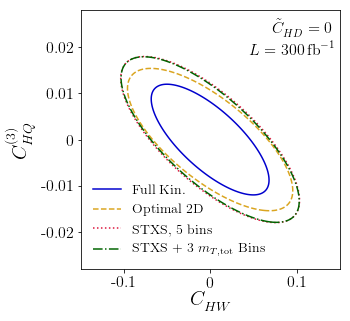

In [255]:
_, ax = plot_contours(
    [  
     project_information( fi_sally_wbkgs_met_mean_rot, [1,2]),
     project_information( fi_sally_wbkgs_2d_mean_rot, [1,2]),
     project_information( fi_stxs_5bins_mean_rot, [1,2]),
     project_information( fi_imp2_stxs_mean_rot, [1,2]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-','--',':','-.'],
    xrange=(-1.5,1.5),
    yrange=(-2.8,2.8),
    contour_distance=2.4476,
    xlabel=r'$C_{HW}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=10.0,
    scale_y=100.,
)

plt.legend(handles=imp_legend_talk, loc='lower left',frameon=False)
plt.text(.48*ax.get_xlim()[1], .8*ax.get_ylim()[1],r'$\tilde{C}_{HD}^{\phantom{(3)}} = 0$',fontsize=16)
plt.text(0.30*ax.get_xlim()[1],.65*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

#plt.savefig('plots/imp_contours_wq_proj_talk.pdf')

#### Profiled

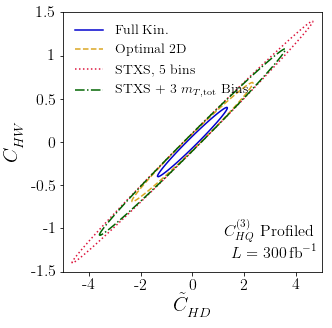

In [256]:
_, ax = plot_contours(
    [  
     profile_information( fi_sally_wbkgs_met_mean_rot, [0,1]),
     profile_information( fi_sally_wbkgs_2d_mean_rot, [0,1]),
     profile_information( fi_stxs_5bins_mean_rot, [0,1]),
     profile_information( fi_imp2_stxs_mean_rot, [0,1]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-','--',':','-.'],
    xrange=(-5,5),
    yrange=(-15,15),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
    scale_x=1.0,
    scale_y=10.,
)

plt.legend(handles=imp_legend_talk, loc='upper left',frameon=False)
plt.text(0.24*ax.get_xlim()[1], -.75*ax.get_ylim()[1], r'$C_{HQ}^{(3)}$ Profiled', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], -.9*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

#plt.savefig('plots/imp_contours_dw_prof_talk.pdf')

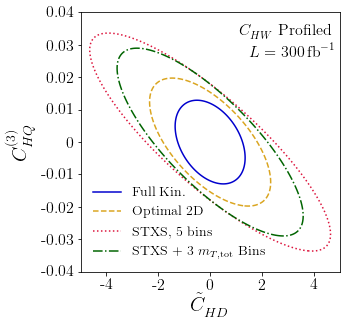

In [257]:
_, ax = plot_contours(
    [  
     profile_information( fi_sally_wbkgs_met_mean_rot, [0,2]),
     profile_information( fi_sally_wbkgs_2d_mean_rot, [0,2]),
     profile_information( fi_stxs_5bins_mean_rot, [0,2]),
     profile_information( fi_imp2_stxs_mean_rot, [0,2]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-','--',':','-.'],
    xrange=(-5,5),
    yrange=(-4,4),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=1.0,
    scale_y=100.,
)

plt.legend(handles=imp_legend_talk, loc='lower left',frameon=False)
plt.text(0.22*ax.get_xlim()[1], 0.8*ax.get_ylim()[1], r'$C_{HW}^{\phantom{(3)}}$ Profiled', fontsize=16)
plt.text(0.30*ax.get_xlim()[1], .65*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

#plt.savefig('plots/imp_contours_dq_prof_talk.pdf')

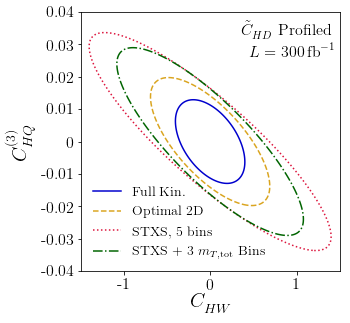

In [258]:
#_, ax = plot_contours(
    [  
     profile_information( fi_sally_wbkgs_met_mean_rot, [1,2]),
     profile_information( fi_sally_wbkgs_2d_mean_rot, [1,2]),
     profile_information( fi_stxs_5bins_mean_rot, [1,2]),
     profile_information( fi_imp2_stxs_mean_rot, [1,2]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-','--',':','-.'],
    xrange=(-15,15),
    yrange=(-4,4),
    contour_distance=2.4476,
    xlabel=r'$C_{HW}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=10.0,
    scale_y=100.,
)

plt.legend(handles=imp_legend_talk, loc='lower left',frameon=False)
plt.text(0.24*ax.get_xlim()[1], 0.8*ax.get_ylim()[1],r'$\tilde{C}_{HD}^{\phantom{(3)}}$ Profiled',fontsize=16)
plt.text(0.30*ax.get_xlim()[1], .65*ax.get_ylim()[1],  r'$L = 300\,\mathrm{fb}^{-1}$', fontsize=16)

plt.savefig('plots/imp_contours_wq_prof_talk.pdf')

## Other Plots / Comparisons

### Comparing the Number of Bins in 2D

In [207]:
comp_imp_legend = [
    Line2D([0],[0], color=col_sally_met, ls='-', label=r'Optimal 2D'),
    Line2D([0],[0], color=col_sally_2d, ls='--', label=r'Imp. (2 bins)'),
    Line2D([0],[0], color=col_stxs_5bins, ls=':',  label='Imp. (3 bins)'),
    Line2D([0],[0], color=col_imp_stxs, ls='-.', label=r'Imp. (4 bins)'),
]

#### Projected

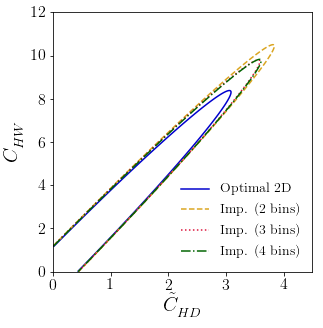

In [218]:
_, ax = plot_contours(
    [  
     project_information( fi_sally_wbkgs_2d_mean_rot, [0,1]),
     project_information( fi_imp2_stxs_mean_rot, [0,1]),
     project_information( fi_imp_stxs_mean_rot, [0,1]),
     project_information( fi_imp4_stxs_mean_rot, [0,1]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],    
    linestyles=['-','--',':','-.'],
    xrange=(0,4.5),
    yrange=(0,12),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
)

plt.legend(handles=comp_imp_legend, loc='lower right',frameon=False)

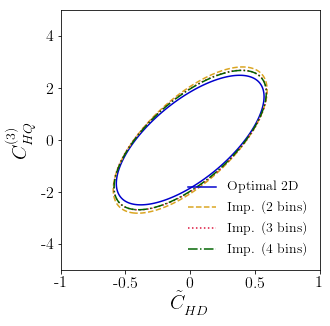

In [214]:
_ = plot_contours(
    [  
     project_information( fi_sally_wbkgs_2d_mean_rot, [0,2]),
     project_information( fi_imp2_stxs_mean_rot, [0,2]),
     project_information( fi_imp_stxs_mean_rot, [0,2]),
     project_information( fi_imp4_stxs_mean_rot, [0,2]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],    
    linestyles=['-','--',':','-.'],
    xrange=(-1,1),
    yrange=(-5,5),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
)

plt.legend(handles=comp_imp_legend, loc='lower right',frameon=False)

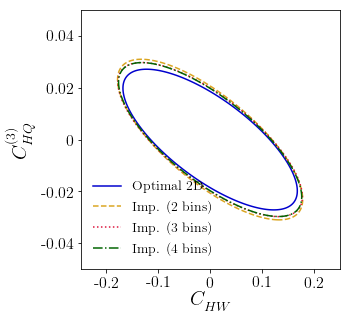

In [216]:
_ = plot_contours(
    [  
     project_information( fi_sally_wbkgs_2d_mean_rot, [1,2]),
     project_information( fi_imp2_stxs_mean_rot, [1,2]),
     project_information( fi_imp_stxs_mean_rot, [1,2]),
     project_information( fi_imp4_stxs_mean_rot, [1,2]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],    
    linestyles=['-','--',':','-.'],
    xrange=(-2.5,2.5),
    yrange=(-5,5),
    contour_distance=2.4476,
    xlabel=r'$C_{HW}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=10.0,
    scale_y=100.,
)

plt.legend(handles=comp_imp_legend, loc='lower left',frameon=False)

#### Profiled

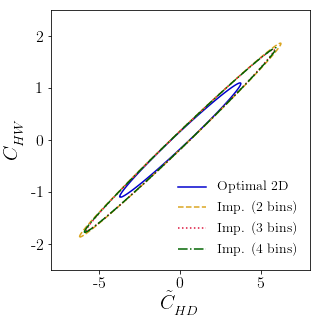

In [223]:
_ = plot_contours(
    [  
     profile_information( fi_sally_wbkgs_2d_mean_rot, [0,1]),
     profile_information( fi_imp2_stxs_mean_rot, [0,1]),
     profile_information( fi_imp_stxs_mean_rot, [0,1]),
     profile_information( fi_imp4_stxs_mean_rot, [0,1]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-','--',':','-.'],
    xrange=(-8,8),
    yrange=(-25,25),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HW}^{\phantom{(3)}}$',
    scale_x=1.0,
    scale_y=10.,
)

plt.legend(handles=comp_imp_legend, loc='lower right',frameon=False)

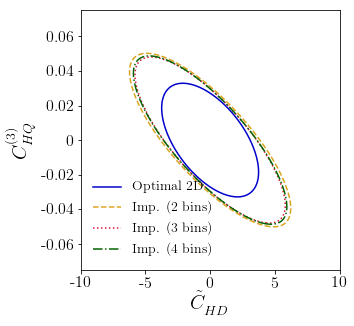

In [220]:
_ = plot_contours(
    [  
     profile_information( fi_sally_wbkgs_2d_mean_rot, [0,2]),
     profile_information( fi_imp2_stxs_mean_rot, [0,2]),
     profile_information( fi_imp_stxs_mean_rot, [0,2]),
     profile_information( fi_imp4_stxs_mean_rot, [0,2]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-','--',':','-.'],
    xrange=(-10,10),
    yrange=(-7.5,7.5),
    contour_distance=2.4476,
    xlabel=r'$\tilde{C}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=1.0,
    scale_y=100.,
)

plt.legend(handles=comp_imp_legend, loc='lower left',frameon=False)

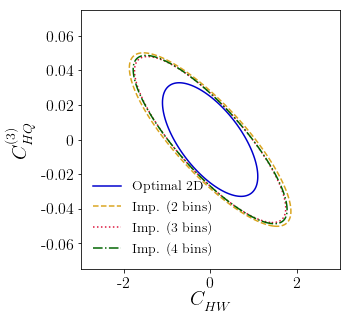

In [221]:
_ = plot_contours(
    [  
     profile_information( fi_sally_wbkgs_2d_mean_rot, [1,2]),
     profile_information( fi_imp2_stxs_mean_rot, [1,2]),
     profile_information( fi_imp_stxs_mean_rot, [1,2]),
     profile_information( fi_imp4_stxs_mean_rot, [1,2]),
    ],
    colors=[ col_sally_met, col_sally_2d, col_stxs_5bins, col_imp_stxs ],
    linestyles=['-','--',':','-.'],
    xrange=(-30,30),
    yrange=(-7.5,7.5),
    contour_distance=2.4476,
    xlabel=r'$C_{HW}^{\phantom{(3)}}$',
    ylabel=r'$C_{HQ}^{(3)}$',
    scale_x=10.0,
    scale_y=100.,
)

plt.legend(handles=comp_imp_legend, loc='lower left',frameon=False)

## Information in $\cos\theta_W^*$

In [ ]:
thetaw_legend = [
    Line2D([0],[0], color=my_colors[0], ls='-', label=r'SALLY (MET)'),
    Line2D([0],[0], color=my_colors[1], ls='--', label=r'Optimal 2D'),
    Line2D([0],[0], color=my_colors[2], ls=':', label='Optimal $p_{T,W}$'),
    Line2D([0],[0], color=my_colors[3], ls='-.', label=r'$p_{T,W}$ + $\cos\theta_W$'),
#    Line2D([0],[0], color=my_colors[4], ls=(0, (3, 1, 1, 1, 1, 1)), label='Fine Bins')
]

#### Projected

In [ ]:
_ = plot_contours(
    [  
     project_information( fi_sally_wbkgs_met_mean_rot, [0,1]),
     project_information( fi_sally_wbkgs_2d_mean_rot, [0,1]),
     project_information( fi_sally_wbkgs_ptw_mean_rot, [0,1]),
     project_information( fi_sally_wbkgs_2dthetaw_mean_rot, [0,1]),
    ],
    colors=[my_colors[0], my_colors[1], my_colors[2], my_colors[3]],
    linestyles=['-','--',':','-.'],
    xrange=(-16,16),
    yrange=(-45,45),
    contour_distance=2.4476,
    xlabel=r'$\tilde{c}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$10 \times c_{HW}^{\phantom{(3)}}$'
)

plt.legend(handles=thetaw_legend, loc='upper left',frameon=False)

#plt.savefig('plots/imp_contours_dw_proj.pdf')

In [ ]:
_ = plot_contours(
    [  
     project_information( fi_sally_wbkgs_met_mean_rot, [0,2]),
     project_information( fi_sally_wbkgs_2d_mean_rot, [0,2]),
     project_information( fi_sally_wbkgs_ptw_mean_rot, [0,2]),
     project_information( fi_sally_wbkgs_2dthetaw_mean_rot, [0,2]),
    ],
    colors=[my_colors[0], my_colors[1], my_colors[2], my_colors[3]],
    linestyles=['-','--',':','-.'],
    xrange=(-3.5,3.5),
    yrange=(-20,20),
    contour_distance=2.4476,
    xlabel=r'$\tilde{c}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$100 \times C_{HQ}^{(3)}$'
)

plt.legend(handles=thetaw_legend, loc='upper left',frameon=False)

#plt.savefig('plots/imp_contours_dq_proj.pdf')

In [ ]:
_ = plot_contours(
    [  
     project_information( fi_sally_wbkgs_met_mean_rot, [1,2]),
     project_information( fi_sally_wbkgs_2d_mean_rot, [1,2]),
     project_information( fi_sally_wbkgs_ptw_mean_rot, [1,2]),
     project_information( fi_sally_wbkgs_2dthetaw_mean_rot, [1,2]),
    ],
    colors=[my_colors[0], my_colors[1], my_colors[2], my_colors[3]],
    linestyles=['-','--',':','-.'],
    xrange=(-10,10),
    yrange=(-20,20),
    contour_distance=2.4476,
    xlabel=r'$10 \times c_{HW}^{\phantom{(3)}}$',
    ylabel=r'$100 \times C_{HQ}^{(3)}$'
)

plt.legend(handles=thetaw_legend, loc='upper right',frameon=False)

#plt.savefig('plots/imp_contours_wq_proj.pdf')

#### Profiled

In [ ]:
_ = plot_contours(
    [  
     profile_information( fi_sally_wbkgs_met_mean_rot, [0,1]),
     profile_information( fi_sally_wbkgs_2d_mean_rot, [0,1]),
     profile_information( fi_sally_wbkgs_ptw_mean_rot, [0,1]),
     profile_information( fi_sally_wbkgs_2dthetaw_mean_rot, [0,1]),
    ],
    colors=[my_colors[0], my_colors[1], my_colors[2], my_colors[3]],
    linestyles=['-','--',':','-.'],
    xrange=(-30,30),
    yrange=(-90,90),
    contour_distance=2.4476,
    xlabel=r'$\tilde{c}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$10 \times c_{HW}^{\phantom{(3)}}$'
)

plt.legend(handles=thetaw_legend, loc='upper left',frameon=False)

#plt.savefig('plots/imp_contours_dw_prof.pdf')

In [ ]:
_ = plot_contours(
    [  
     profile_information( fi_sally_wbkgs_met_mean_rot, [0,2]),
     profile_information( fi_sally_wbkgs_2d_mean_rot, [0,2]),
     profile_information( fi_sally_wbkgs_ptw_mean_rot, [0,2]),
     profile_information( fi_sally_wbkgs_2dthetaw_mean_rot, [0,2]),
    ],
    colors=[my_colors[0], my_colors[1], my_colors[2], my_colors[3]],
    linestyles=['-','--',':','-.'],
    xrange=(-30,30),
    yrange=(-30,30),
    contour_distance=2.4476,
    xlabel=r'$\tilde{c}_{HD}^{\phantom{(3)}}$',
    ylabel=r'$100 \times C_{HQ}^{(3)}$'
)

plt.legend(handles=thetaw_legend, loc='upper right',frameon=False)

#plt.savefig('plots/imp_contours_dq_prof.pdf')

In [ ]:
_ = plot_contours(
    [  
     profile_information( fi_sally_wbkgs_met_mean_rot, [1,2]),
     profile_information( fi_sally_wbkgs_2d_mean_rot, [1,2]),
     profile_information( fi_sally_wbkgs_ptw_mean_rot, [1,2]),
     profile_information( fi_sally_wbkgs_2dthetaw_mean_rot, [1,2]),
    ],
    colors=[my_colors[0], my_colors[1], my_colors[2], my_colors[3]],
    linestyles=['-','--',':','-.'],
    xrange=(-90,90),
    yrange=(-30,30),
    contour_distance=2.4476,
    xlabel=r'$10 \times c_{HW}^{\phantom{(3)}}$',
    ylabel=r'$100 \times C_{HQ}^{(3)}$'
)

plt.legend(handles=thetaw_legend, loc='upper right',frameon=False)

#plt.savefig('plots/imp_contours_wq_prof.pdf')